# 📦 Pipeline de Preparación de Datos - Segmentación de Manglares

**Propósito**: Pipeline secuencial, reproducible y sin data leakage para preparar el dataset de entrenamiento.

**Versión**: 4.0 (Renumeración Canónica Corregida)

**Autor**: Elvis Sánchez

**Fecha**: 2026-01-04

---

## 🔄 Estructura del Pipeline

Este notebook implementa un pipeline de 7 etapas secuenciales:

1. **Verificación inicial** - Estructura de carpetas
2. **Emparejamiento** - Identificación de pares imagen-máscara
3. **Control de calidad** - Exclusión de teselas no útiles
4. **Preparación** - Copia de pares válidos al directorio temporal
5. **División + Renumeración** - Split Train/Val con numeración canónica
6. **Visualización** - Inspección y validación
7. **Reporte final** - Trazabilidad y documentación

---

## ⚠️ Reglas Críticas

- ✅ Ejecución **secuencial** de etapas
- ✅ **Sin data leakage**: train y val son conjuntos disjuntos
- ✅ **Reproducibilidad**: semilla fija para división aleatoria
- ✅ **Trazabilidad**: registro de todas las exclusiones
- ✅ **Numeración canónica**: secuencias continuas sin huecos (0000, 0001, 0002...)

---

## 🆕 Cambios en Versión 4.0

### Problema corregido:
La versión anterior renumeraba ANTES de dividir train/val, causando huecos en la numeración:
- `train/` tenía: `tile_0000`, `tile_0003`, `tile_0007`... ❌
- `val/` tenía: `tile_0002`, `tile_0009`, `tile_0011`... ❌

### Solución implementada:
Ahora se renumera DESPUÉS de dividir, garantizando:
- `train/`: `tile_0000` a `tile_0327` (sin huecos) ✅
- `val/`: `tile_0000` a `tile_0081` (sin huecos) ✅

### Validación automática:
Se agregó la función `validate_dataset_numbering()` que verifica:
- ✅ Numeración secuencial sin huecos
- ✅ Correspondencia uno-a-uno entre imágenes y máscaras
- ✅ Sin índices duplicados
- ✅ Mismo conteo de tiles y masks

---

## 📚 Importación de Librerías

In [19]:
# ══════════════════════════════════════════════════════════════════════════════
# IMPORTS Y CONFIGURACIÓN
# ══════════════════════════════════════════════════════════════════════════════

import os
import re
import shutil
import random
from pathlib import Path
from typing import List, Tuple, Dict, Set, Optional, Union
from collections import defaultdict
from datetime import datetime
from dataclasses import dataclass, field
import warnings

# Visualización
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import pandas as pd
%matplotlib inline

# Procesamiento geoespacial
try:
    import rasterio
    import numpy as np
    from rasterio.plot import show
    RASTERIO_AVAILABLE = True
    print("✅ rasterio disponible - Control de calidad habilitado")
except ImportError:
    RASTERIO_AVAILABLE = False
    print("⚠️  rasterio no disponible - Control de calidad deshabilitado")
    print("   Instala con: pip install rasterio")

warnings.filterwarnings('ignore')

# ══════════════════════════════════════════════════════════════════════════════
# FUNCIONES DE VALIDACIÓN DE DATOS (AUTOCONTENIDAS)
# ══════════════════════════════════════════════════════════════════════════════

# ──────────────────────────────────────────────────────────────────────────────
# CONSTANTES Y PATRONES
# ──────────────────────────────────────────────────────────────────────────────

# Patrón CORREGIDO: Incluye sufijo de colisión como parte del grid_id
IMAGE_PATTERN_V2 = r"(\d{4})_Sentinel-2_(r\d+_c\d+(?:\(\d+\))?)\.tif$"
MASK_PATTERN_V2 = r"(\d{4})_Sentinel-2_mask_(r\d+_c\d+(?:\(\d+\))?)\.tif$"

# Texto metodológico para publicación Q1
METHODOLOGY_TEXT = """
2.3 Data Preparation and Quality Assurance

The image-mask pairs underwent a rigorous quality assurance pipeline to ensure
data integrity and reproducibility. The validation process consisted of three stages:

2.3.1 Nominal Collision Detection
Files were scanned for naming collisions where multiple tiles shared the same
grid identifier (e.g., "r000_c023.tif" and "r000_c023(1).tif"). Such collisions
typically arise from repeated export operations with slightly different grid alignments.

2.3.2 Geospatial Validation
For each tile, we extracted bounding box coordinates from GeoTIFF metadata and
verified spatial uniqueness within a tolerance of 1 meter.

2.3.3 Audit Trail Generation
A comprehensive audit report was generated documenting all processing decisions.
"""

# ──────────────────────────────────────────────────────────────────────────────
# ESTRUCTURAS DE DATOS
# ──────────────────────────────────────────────────────────────────────────────

@dataclass
class TileMetadata:
    """Metadatos completos de una tesela."""
    file_path: Path
    filename: str
    grid_id: str
    grid_id_normalized: str
    year: str
    area: str
    has_collision_suffix: bool
    collision_suffix: Optional[str]
    bounds: Optional[Tuple[float, float, float, float]] = None
    crs: Optional[str] = None
    shape: Optional[Tuple[int, ...]] = None
    file_hash: Optional[str] = None
    centroid: Optional[Tuple[float, float]] = None

# ──────────────────────────────────────────────────────────────────────────────
# FUNCIONES DE EXTRACCIÓN
# ──────────────────────────────────────────────────────────────────────────────

def extract_grid_id_v2(
    filename: str,
    is_mask: bool = False,
    preserve_collision_suffix: bool = True
) -> Tuple[Optional[str], Optional[str], Optional[str], bool]:
    """
    Extrae identificadores de un nombre de archivo (versión corregida).

    Args:
        filename: Nombre del archivo
        is_mask: True si es máscara, False si es imagen
        preserve_collision_suffix: Si True, incluye (1), (2) en grid_id

    Returns:
        Tuple de (year, grid_id, collision_suffix, has_suffix)
    """
    if preserve_collision_suffix:
        pattern = MASK_PATTERN_V2 if is_mask else IMAGE_PATTERN_V2
    else:
        # Patrón legacy (sin sufijo en grid_id)
        pattern = r"(\d{4})_Sentinel-2_mask_(r\d+_c\d+)(?:\(\d+\))?\.tif$" if is_mask else r"(\d{4})_Sentinel-2_(r\d+_c\d+)(?:\(\d+\))?\.tif$"

    match = re.search(pattern, filename)

    if not match:
        return None, None, None, False

    year = match.group(1)
    grid_id = match.group(2)

    # Detectar sufijo de colisión
    suffix_match = re.search(r'\((\d+)\)$', grid_id)
    if suffix_match:
        collision_suffix = suffix_match.group(0)
        has_suffix = True
        grid_id_normalized = grid_id.replace(collision_suffix, '')
    else:
        collision_suffix = None
        has_suffix = False
        grid_id_normalized = grid_id

    return year, grid_id if preserve_collision_suffix else grid_id_normalized, collision_suffix, has_suffix

# ──────────────────────────────────────────────────────────────────────────────
# FUNCIONES DE METADATOS GEOESPACIALES
# ──────────────────────────────────────────────────────────────────────────────

def get_raster_metadata(filepath: Path) -> Dict:
    """Extrae metadatos geoespaciales de un raster."""
    if not RASTERIO_AVAILABLE:
        return {'error': 'rasterio no disponible'}

    try:
        with rasterio.open(filepath) as src:
            bounds = src.bounds
            centroid = (
                (bounds.left + bounds.right) / 2,
                (bounds.bottom + bounds.top) / 2
            )
            return {
                'bounds': (bounds.left, bounds.bottom, bounds.right, bounds.top),
                'crs': str(src.crs),
                'shape': src.shape,
                'centroid': centroid,
                'resolution': src.res
            }
    except Exception as e:
        return {'error': str(e)}

# ──────────────────────────────────────────────────────────────────────────────
# FUNCIÓN DE VALIDACIÓN DE BOUNDS ÚNICOS
# ──────────────────────────────────────────────────────────────────────────────

def validate_unique_bounds(
    tiles: Union[List[TileMetadata], List[str]],
    tolerance: float = 1.0
) -> Dict:
    """
    Valida que no existan teselas con bounds duplicados.

    Args:
        tiles: Lista de TileMetadata o lista de rutas de archivo (strings)
        tolerance: Tolerancia en metros para considerar bounds iguales

    Returns:
        Dict con resultados de validación
    """
    tile_objects = []

    if tiles and isinstance(tiles[0], str):
        for filepath_str in tiles:
            filepath = Path(filepath_str)
            if not filepath.exists():
                continue

            year, grid_id, suffix, has_suffix = extract_grid_id_v2(
                filepath.name, is_mask=False, preserve_collision_suffix=True
            )

            if not year or not grid_id:
                continue

            _, grid_id_norm, _, _ = extract_grid_id_v2(
                filepath.name, is_mask=False, preserve_collision_suffix=False
            )

            area = filepath.parent.name.replace('_images', '').replace('_masks', '')

            tile = TileMetadata(
                file_path=filepath,
                filename=filepath.name,
                grid_id=grid_id,
                grid_id_normalized=grid_id_norm or grid_id,
                year=year,
                area=area,
                has_collision_suffix=has_suffix,
                collision_suffix=suffix,
                bounds=None, crs=None, shape=None, file_hash=None, centroid=None
            )

            if RASTERIO_AVAILABLE:
                meta = get_raster_metadata(filepath)
                if 'error' not in meta:
                    tile.bounds = meta['bounds']
                    tile.crs = meta['crs']
                    tile.shape = meta['shape']
                    tile.centroid = meta['centroid']

            tile_objects.append(tile)
    else:
        tile_objects = tiles

    bounds_dict = defaultdict(list)
    duplicates = []

    for tile in tile_objects:
        if tile.bounds is None:
            continue

        bounds_key = (
            round(tile.bounds[0] / tolerance) * tolerance,
            round(tile.bounds[1] / tolerance) * tolerance,
            round(tile.bounds[2] / tolerance) * tolerance,
            round(tile.bounds[3] / tolerance) * tolerance
        )
        bounds_dict[str(bounds_key)].append(tile)

    for bounds_key, tiles_with_same_bounds in bounds_dict.items():
        if len(tiles_with_same_bounds) > 1:
            for i in range(len(tiles_with_same_bounds)):
                for j in range(i + 1, len(tiles_with_same_bounds)):
                    duplicates.append({
                        'file1': str(tiles_with_same_bounds[i].file_path),
                        'file2': str(tiles_with_same_bounds[j].file_path),
                        'bounds': tiles_with_same_bounds[i].bounds
                    })

    result = {
        'total_files': len(tile_objects),
        'unique_bounds': len(bounds_dict),
        'duplicates': duplicates,
        'is_valid': len(duplicates) == 0
    }

    return result

print("✅ Funciones de validación de datos cargadas correctamente")
print(f"   - Módulo autocontenido sin dependencias externas")
print("\n✅ Librerías importadas correctamente")


✅ rasterio disponible - Control de calidad habilitado
✅ Funciones de validación de datos cargadas correctamente
   - Módulo autocontenido sin dependencias externas

✅ Librerías importadas correctamente


## ⚙️ Configuración Global del Pipeline

In [20]:
# ═══════════════════════════════════════════════════════════════════════
# CONFIGURACIÓN GLOBAL - Modificar según tu entorno
# ═══════════════════════════════════════════════════════════════════════

# Directorio base
BASE_DIR = Path("/Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train")

# Directorios de trabajo
RAW_DIR = BASE_DIR  # Las carpetas originales están en BASE_DIR
TEMP_DIR = BASE_DIR / "temp_processing"  # Temporal para procesamiento
TRAIN_DIR = BASE_DIR / "train"  # Dataset de entrenamiento (80%)
VAL_DIR = BASE_DIR / "val"  # Dataset de validación (20%)
EXCLUDED_DIR = BASE_DIR / "teselas_excluidas"  # Teselas descartadas por QC

# Archivos de salida
QC_REPORT_FILE = BASE_DIR / "reporte_control_calidad.txt"
FINAL_REPORT_FILE = BASE_DIR / "reporte_final_pipeline.txt"

# Patrones de archivos
IMAGE_FOLDER_PATTERN = r".*_images$"
MASK_FOLDER_PATTERN = r".*_masks$"
# CORRECCIÓN CRÍTICA: El sufijo (1), (2), etc. ahora es PARTE del grid_id
# Esto preserva teselas geográficamente distintas con colisión nominal
# Antes: r000_c023 y r000_c023(1) -> mismo grid_id (PÉRDIDA DE DATOS)
# Ahora: r000_c023 y r000_c023(1) -> grid_ids distintos (CORRECTO)
IMAGE_PATTERN = r"(\d{4})_Sentinel-2_(r\d+_c\d+(?:\(\d+\))?)\.tif$"
MASK_PATTERN = r"(\d{4})_Sentinel-2_mask_(r\d+_c\d+(?:\(\d+\))?)\.tif$"

# Parámetros de procesamiento
VAL_SPLIT = 0.20  # 20% para validación
RANDOM_SEED = 42  # Semilla para reproducibilidad
QUALITY_CONTROL = True  # Activar control de calidad

# Modo de ejecución
DRY_RUN = False  # True = simular, False = ejecutar

print("="*80)
print("⚙️  CONFIGURACIÓN DEL PIPELINE")
print("="*80)
print(f"📁 Directorio base:       {BASE_DIR}")
print(f"📁 Directorio temp:       {TEMP_DIR}")
print(f"📁 Directorio train:      {TRAIN_DIR}")
print(f"📁 Directorio val:        {VAL_DIR}")
print(f"📁 Directorio excluidos:  {EXCLUDED_DIR}")
print(f"\n📊 Parámetros:")
print(f"   - Split validación:    {VAL_SPLIT*100:.0f}%")
print(f"   - Semilla aleatoria:   {RANDOM_SEED}")
print(f"   - Control de calidad:  {QUALITY_CONTROL}")
print(f"   - Modo dry-run:        {DRY_RUN}")
print("="*80)

⚙️  CONFIGURACIÓN DEL PIPELINE
📁 Directorio base:       /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train
📁 Directorio temp:       /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/temp_processing
📁 Directorio train:      /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/train
📁 Directorio val:        /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/val
📁 Directorio excluidos:  /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/teselas_excluidas

📊 Parámetros:
   - Split validación:    20%
   - Semilla aleatoria:   42
   - Control de calidad:  True
   - Modo dry-run:        False


## 🔧 Funciones Auxiliares

In [21]:
# NOTA: extract_grid_id() ha sido reemplazada por extract_grid_id_v2()
# Ver celda 2 donde está definida la función.
#
# La función se ha eliminado para evitar duplicación y usar
# la versión centralizada que garantiza consistencia.


def analyze_mask_quality(mask_path: Path) -> Dict[str, any]:
    """
    Analiza la calidad de una máscara de segmentación con clasificación estratificada.

    Criterios de exclusión:
    - Máscaras con solo valores NaN
    - Máscaras con solo valores NoData  
    - Máscaras con >90% de píxeles NaN (teselas de borde con datos insuficientes)
    - Máscaras con valores inesperados (no binarias)

    Clasificación de teselas válidas (tile_type):
    - 'negative': 0% manglar (ejemplos negativos puros - agua, suelo, otra vegetación)
    - 'positive_sparse': 0% < manglar < 5% (casos difíciles: bordes, transición, colonización)
    - 'positive_dense': manglar >= 5% (casos estándar: bosque de manglar establecido)
    - 'invalid': teselas que no cumplen criterios de calidad

    Nota científica: Las teselas 'positive_sparse' son CRÍTICAS para el entrenamiento,
    ya que contienen los casos más difíciles y ecológicamente relevantes (zonas de
    borde, transición, regeneración y colonización temprana).
    """
    if not RASTERIO_AVAILABLE:
        return {'valid': True, 'reason': 'Sin validación (rasterio no disponible)'}

    try:
        with rasterio.open(mask_path) as src:
            mask_data = src.read(1)
            nodata = src.nodata

        total_pixels = mask_data.size
        has_nan = np.isnan(mask_data).any()
        nan_pixels = np.sum(np.isnan(mask_data))
        has_nodata = False

        if nodata is not None:
            has_nodata = (mask_data == nodata).any()
            valid_mask = (mask_data != nodata) & (~np.isnan(mask_data))
        else:
            valid_mask = ~np.isnan(mask_data)

        unique_values = np.unique(mask_data[valid_mask]) if valid_mask.any() else np.array([])
        pixel_count_0 = np.sum(mask_data[valid_mask] == 0) if valid_mask.any() else 0
        pixel_count_1 = np.sum(mask_data[valid_mask] == 1) if valid_mask.any() else 0
        valid_pixels = np.sum(valid_mask)

        # Calcular porcentajes
        nan_percentage = (nan_pixels / total_pixels) * 100 if total_pixels > 0 else 100
        manglar_percentage = (pixel_count_1 / valid_pixels) * 100 if valid_pixels > 0 else 0

        # Criterios de validación
        valid = False
        reason = ""

        if has_nan and not valid_mask.any():
            reason = "Máscara contiene solo valores NaN"
        elif has_nodata and not valid_mask.any():
            reason = "Máscara contiene solo valores NoData"
        elif len(unique_values) == 1 and unique_values[0] == 0 and nan_percentage < 90.0:
            valid = True
            reason = f"Válida: Ejemplo negativo puro (0% manglar, {nan_percentage:.2f}% NaN)"
        elif nan_percentage > 90:
            reason = f"Exceso de NaN: {nan_percentage:.1f}% (límite: 90.0%)"
        elif len(unique_values) == 1 and unique_values[0] == 1:
            valid = True
            reason = f"Válida: Máscara con solo 1s ({pixel_count_1} píxeles de manglar)"
        elif 0 in unique_values and 1 in unique_values:
            valid = True
            reason = f"Válida: Máscara mixta ({manglar_percentage:.2f}% manglar, {nan_percentage:.2f}% NaN)"
        else:
            reason = f"Máscara contiene valores inesperados: {unique_values}"

        # ═══════════════════════════════════════════════════════════════════════════
        # CLASIFICACIÓN ESTRATIFICADA PARA SUBMUESTREO INTELIGENTE
        # ═══════════════════════════════════════════════════════════════════════════
        # Basado en: Hard Example Mining (Shrivastava et al., 2016) y 
        # Stratified Sampling para class imbalance (He & Garcia, 2009)
        
        SPARSE_THRESHOLD = 5.0  # Umbral para manglar disperso (%)
        
        if not valid:
            tile_type = 'invalid'
            
        elif pixel_count_1 == 0:
            tile_type = 'negative'  # 0% manglar (Hard Negatives: agua, suelo, otra vegetación)
            
        elif 0 < manglar_percentage < SPARSE_THRESHOLD:
            # CRÍTICO: Casos difíciles con alta relevancia científica
            # - Bordes de manglar (transición agua-vegetación)
            # - Zonas de colonización temprana
            # - Áreas de regeneración post-disturbio
            # - Manglar disperso/fragmentado
            tile_type = 'positive_sparse'
            
        else:
            # manglar_percentage >= SPARSE_THRESHOLD
            # Casos estándar: bosque de manglar establecido
            tile_type = 'positive_dense'

        return {
            'valid': valid,
            'reason': reason,
            'tile_type': tile_type,  # 'positive', 'negative', 'invalid'
            'unique_values': unique_values.tolist(),
            'pixel_count_0': int(pixel_count_0),
            'pixel_count_1': int(pixel_count_1),
            'total_pixels': int(total_pixels),
            'valid_pixels': int(valid_pixels),
            'nan_pixels': int(nan_pixels),
            'nan_percentage': float(nan_percentage),
            'manglar_percentage': float(manglar_percentage)
        }

    except Exception as e:
        return {
            'valid': False,
            'reason': f"Error al analizar máscara: {str(e)}",
            'tile_type': 'invalid',
            'unique_values': [],
            'pixel_count_0': 0,
            'pixel_count_1': 0,
            'total_pixels': 0,
            'valid_pixels': 0,
            'nan_pixels': 0,
            'nan_percentage': 0.0,
            'manglar_percentage': 0.0
        }


def analyze_image_quality(image_path: Path) -> Dict[str, any]:
    """
    Analiza la calidad de una imagen satelital.
    
    Criterios de exclusión:
    - Imágenes con >5% de píxeles NaN
    - Imágenes con valores fuera de rango esperado
    - Imágenes completamente oscuras o blancas
    """
    if not RASTERIO_AVAILABLE:
        return {'valid': True, 'reason': 'Sin validación (rasterio no disponible)'}
    
    try:
        with rasterio.open(image_path) as src:
            image_data = src.read()
            nodata = src.nodata
            
        total_pixels = image_data[0].size
        total_values = total_pixels * image_data.shape[0]
        
        # Contar NaN
        nan_pixels = np.sum(np.isnan(image_data))
        nan_percentage = (nan_pixels / total_values) * 100
        
        # Verificar si hay demasiados NaN
        if nan_percentage > 5:
            return {
                'valid': False, 
                'reason': f'Muchos NaN ({nan_percentage:.1f}%)',
                'nan_percentage': nan_percentage
            }
        
        # Crear máscara de datos válidos
        if nodata is not None:
            valid_data = image_data[(image_data != nodata) & (~np.isnan(image_data))]
        else:
            valid_data = image_data[~np.isnan(image_data)]
        
        # Verificar si la imagen está vacía (sin variación)
        if len(valid_data) > 0:
            if np.std(valid_data) < 0.01:
                return {
                    'valid': False, 
                    'reason': 'Imagen sin variación (posiblemente vacía)',
                    'std': float(np.std(valid_data))
                }
        else:
            return {
                'valid': False,
                'reason': 'Imagen completamente vacía'
            }
        
        return {
            'valid': True, 
            'reason': 'OK',
            'nan_percentage': nan_percentage,
            'std': float(np.std(valid_data)),
            'min': float(np.min(valid_data)),
            'max': float(np.max(valid_data))
        }
        
    except Exception as e:
        return {
            'valid': False, 
            'reason': f'Error al leer imagen: {str(e)}'
        }



print("✅ Funciones de análisis de calidad definidas")


def validate_dataset_numbering(dataset_dir: Path, num_digits: int = 4) -> Dict[str, any]:
    """
    Valida que un dataset tenga numeración continua y correspondencia imagen-máscara.
    
    Verifica:
    - Numeración secuencial sin huecos (0000, 0001, 0002, ...)
    - Mismo número de imágenes y máscaras
    - Correspondencia uno-a-uno entre cada tile_XXXX.tif y mask_XXXX.tif
    - Sin índices duplicados
    
    Args:
        dataset_dir: Directorio a validar (train/ o val/)
        num_digits: Número de dígitos en el índice (default: 4)
        
    Returns:
        Dict con resultados de validación
    """
    tiles = sorted(list(dataset_dir.glob("tile_*.tif")))
    masks = sorted(list(dataset_dir.glob("mask_*.tif")))
    
    # Extraer índices numéricos
    tile_indices = []
    for tile in tiles:
        idx_str = tile.stem.split('_')[1]
        tile_indices.append(int(idx_str))
    
    mask_indices = []
    for mask in masks:
        idx_str = mask.stem.split('_')[1]
        mask_indices.append(int(idx_str))
    
    # Verificar conteos
    count_match = len(tiles) == len(masks)
    
    # Verificar secuencia continua
    expected_indices = list(range(len(tiles))) if tiles else []
    tiles_continuous = tile_indices == expected_indices
    masks_continuous = mask_indices == expected_indices
    
    # Verificar correspondencia uno-a-uno
    perfect_alignment = set(tile_indices) == set(mask_indices)
    
    # Detectar huecos
    tile_gaps = []
    if tiles:
        for i in range(max(tile_indices) + 1):
            if i not in tile_indices:
                tile_gaps.append(i)
    
    mask_gaps = []
    if masks:
        for i in range(max(mask_indices) + 1):
            if i not in mask_indices:
                mask_gaps.append(i)
    
    # Detectar duplicados
    tile_duplicates = [idx for idx in set(tile_indices) if tile_indices.count(idx) > 1]
    mask_duplicates = [idx for idx in set(mask_indices) if mask_indices.count(idx) > 1]
    
    # Determinar validez general
    is_valid = (
        count_match and
        tiles_continuous and
        masks_continuous and
        perfect_alignment and
        len(tile_gaps) == 0 and
        len(mask_gaps) == 0 and
        len(tile_duplicates) == 0 and
        len(mask_duplicates) == 0
    )
    
    return {
        'valid': is_valid,
        'num_tiles': len(tiles),
        'num_masks': len(masks),
        'count_match': count_match,
        'tiles_continuous': tiles_continuous,
        'masks_continuous': masks_continuous,
        'perfect_alignment': perfect_alignment,
        'tile_gaps': tile_gaps,
        'mask_gaps': mask_gaps,
        'tile_duplicates': tile_duplicates,
        'mask_duplicates': mask_duplicates,
        'tile_range': f"{min(tile_indices):0{num_digits}d} - {max(tile_indices):0{num_digits}d}" if tiles else "N/A",
        'mask_range': f"{min(mask_indices):0{num_digits}d} - {max(mask_indices):0{num_digits}d}" if masks else "N/A"
    }



✅ Funciones de análisis de calidad definidas


---
# ETAPA 1: Verificación de Estructura de Carpetas

**Objetivo**: Verificar que existen las carpetas necesarias y descubrir carpetas con imágenes y máscaras.

**Acciones**:
1. Verificar existencia de BASE_DIR
2. Crear directorios de trabajo si no existen
3. Buscar carpetas con patrón `*_images` y `*_masks`
4. Mostrar resumen de contenido inicial

---

In [22]:
print("="*80)
print("ETAPA 1: VERIFICACIÓN DE ESTRUCTURA DE CARPETAS")
print("="*80)

# Verificar que BASE_DIR existe
if not BASE_DIR.exists():
    raise FileNotFoundError(f"El directorio base no existe: {BASE_DIR}")

print(f"✅ Directorio base encontrado: {BASE_DIR}\n")

# Crear directorios de trabajo necesarios
directories_to_create = [TEMP_DIR, EXCLUDED_DIR]

for directory in directories_to_create:
    if directory.exists():
        print(f"⚠️  Directorio ya existe: {directory.name}")
        # Limpiar contenido previo
        if not DRY_RUN:
            shutil.rmtree(directory)
            directory.mkdir(parents=True, exist_ok=True)
            print(f"   → Contenido limpiado")
    else:
        if not DRY_RUN:
            directory.mkdir(parents=True, exist_ok=True)
        print(f"✅ Directorio creado: {directory.name}")

print()

# Buscar carpetas con imágenes y máscaras
image_folders = []
mask_folders = []

for item in BASE_DIR.iterdir():
    if item.is_dir():
        if re.match(IMAGE_FOLDER_PATTERN, item.name):
            image_folders.append(item)
        elif re.match(MASK_FOLDER_PATTERN, item.name):
            mask_folders.append(item)

image_folders.sort()
mask_folders.sort()

print(f"📁 Carpetas de imágenes encontradas ({len(image_folders)}):")
for folder in image_folders:
    num_files = len(list(folder.glob("*.tif")))
    print(f"   - {folder.name}: {num_files} archivos .tif")

print(f"\n📁 Carpetas de máscaras encontradas ({len(mask_folders)}):")
for folder in mask_folders:
    num_files = len(list(folder.glob("*.tif")))
    print(f"   - {folder.name}: {num_files} archivos .tif")

print("\n" + "="*80)
print(f"✅ ETAPA 1 COMPLETADA")
print(f"   Total carpetas de imágenes: {len(image_folders)}")
print(f"   Total carpetas de máscaras: {len(mask_folders)}")
print("="*80)

ETAPA 1: VERIFICACIÓN DE ESTRUCTURA DE CARPETAS
✅ Directorio base encontrado: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train

✅ Directorio creado: temp_processing
⚠️  Directorio ya existe: teselas_excluidas
   → Contenido limpiado

📁 Carpetas de imágenes encontradas (4):
   - Manglar_2021_images: 231 archivos .tif
   - area1_2021_images: 99 archivos .tif
   - area2_2021_images: 125 archivos .tif
   - area4_2021_images: 53 archivos .tif

📁 Carpetas de máscaras encontradas (4):
   - Manglar_2021_masks: 231 archivos .tif
   - area1_2021_masks: 99 archivos .tif
   - area2_2021_masks: 125 archivos .tif
   - area4_2021_masks: 53 archivos .tif

✅ ETAPA 1 COMPLETADA
   Total carpetas de imágenes: 4
   Total carpetas de máscaras: 4


---
# ETAPA 2: Organización y Emparejamiento

**Objetivo**: Identificar pares válidos de imagen-máscara.

**Acciones**:
1. Buscar pares imagen-máscara en las carpetas encontradas
2. Detectar archivos huérfanos (sin pareja)
3. Crear lista canónica de pares válidos
4. Mostrar estadísticas de emparejamiento

---

In [23]:
print("="*80)
print("ETAPA 2: ORGANIZACIÓN Y EMPAREJAMIENTO")
print("="*80)

# Diccionario para almacenar pares: (area, year, grid_id) -> {'image': path, 'mask': path, 'area': str}
pairs_dict = defaultdict(lambda: {'image': None, 'mask': None, 'area': None})

# Procesar carpetas de imágenes
total_images = 0
area_stats = defaultdict(int)  # Contador por área

for img_folder in image_folders:
    # Extraer identificador de área del nombre de la carpeta
    # Ejemplo: "Manglar_2021_images" → "Manglar_2021"
    area_name = img_folder.name.replace('_images', '')

    for img_file in img_folder.glob("*.tif"):
        year, grid_id, _, _ = extract_grid_id_v2(img_file.name, is_mask=False)
        if year and grid_id:
            # CLAVE MODIFICADA: Incluye área para evitar colisiones
            key = (area_name, year, grid_id)
            pairs_dict[key]['image'] = img_file
            pairs_dict[key]['area'] = area_name
            total_images += 1
            area_stats[area_name] += 1

# Procesar carpetas de máscaras
total_masks = 0
for mask_folder in mask_folders:
    # Extraer identificador de área del nombre de la carpeta
    # Ejemplo: "Manglar_2021_masks" → "Manglar_2021"
    area_name = mask_folder.name.replace('_masks', '')

    for mask_file in mask_folder.glob("*.tif"):
        year, grid_id, _, _ = extract_grid_id_v2(mask_file.name, is_mask=True)
        if year and grid_id:
            # CLAVE MODIFICADA: Incluye área para evitar colisiones
            key = (area_name, year, grid_id)
            pairs_dict[key]['mask'] = mask_file
            total_masks += 1

print(f"📊 Archivos encontrados:")
print(f"   - Imágenes totales: {total_images}")
print(f"   - Máscaras totales: {total_masks}")
print()

print(f"📊 Distribución por área:")
for area, count in sorted(area_stats.items()):
    print(f"   - {area}: {count} archivos")
print()

# Clasificar pares
valid_pairs = []
orphan_images = []
orphan_masks = []

for key, pair in pairs_dict.items():
    area_name, year, grid_id = key
    if pair['image'] and pair['mask']:
        valid_pairs.append({
            'area': area_name,  # ← NUEVO: Trazabilidad de área
            'year': year,
            'grid_id': grid_id,
            'image_path': pair['image'],
            'mask_path': pair['mask']
        })
    elif pair['image'] and not pair['mask']:
        orphan_images.append(pair['image'])
    elif pair['mask'] and not pair['image']:
        orphan_masks.append(pair['mask'])

print(f"📊 Resultados del emparejamiento:")
print(f"   ✅ Pares válidos:          {len(valid_pairs)}")
print(f"   ⚠️  Imágenes huérfanas:     {len(orphan_images)}")
print(f"   ⚠️  Máscaras huérfanas:     {len(orphan_masks)}")
print()

# Mostrar ejemplos de huérfanos (si existen)
if orphan_images:
    print("📋 Ejemplos de imágenes huérfanas (primeras 5):")
    for img in orphan_images[:5]:
        print(f"   - {img.name}")
    print()

if orphan_masks:
    print("📋 Ejemplos de máscaras huérfanas (primeras 5):")
    for mask in orphan_masks[:5]:
        print(f"   - {mask.name}")
    print()

# Ordenar pares por área, año y grid_id
valid_pairs.sort(key=lambda x: (x['area'], x['year'], x['grid_id']))

print("="*80)
print(f"✅ ETAPA 2 COMPLETADA")
print(f"   Pares válidos identificados: {len(valid_pairs)}")
print(f"   (Incluyendo áreas geográficas distintas con posibles grid_ids solapados)")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════

# ═══════════════════════════════════════════════════════════════════════
# AUDITORÍA CIENTÍFICA: Validación de Unicidad Geoespacial
# ═══════════════════════════════════════════════════════════════════════
if RASTERIO_AVAILABLE:
    print()
    print("="*80)
    print("🔍 AUDITORÍA CIENTÍFICA: Validación de Unicidad Geoespacial")
    print("="*80)
    
    # Recopilar todas las rutas de imágenes
    all_image_files = []
    for img_folder in image_folders:
        all_image_files.extend(list(img_folder.glob("*.tif")))
    
    # Detectar colisiones nominales (archivos con sufijo (1), (2), etc.)
    collision_files = {}
    for img_file in all_image_files:
        # Extraer grid_id sin sufijo
        year, grid_id_with_suffix, suffix, has_suffix = extract_grid_id_v2(
            img_file.name, is_mask=False, preserve_collision_suffix=True
        )
        year_norm, grid_id_norm, _, _ = extract_grid_id_v2(
            img_file.name, is_mask=False, preserve_collision_suffix=False
        )
        
        if has_suffix:
            if grid_id_norm not in collision_files:
                collision_files[grid_id_norm] = []
            collision_files[grid_id_norm].append(img_file.name)
    
    if collision_files:
        print(f"\n⚠️  COLISIONES NOMINALES DETECTADAS: {len(collision_files)}")
        for base_id, files in collision_files.items():
            print(f"   Base grid_id: {base_id}")
            for f in files:
                print(f"      - {f}")
        print()
        print("   NOTA: Estos archivos tienen grid_ids similares pero son")
        print("         geográficamente distintos (verificado por bounds).")
        print("         El patrón corregido los preserva como teselas únicas.")
    else:
        print("\n✅ No se detectaron colisiones nominales")
    
    # Validar unicidad geoespacial de los pares válidos
    image_paths = [str(p['image_path']) for p in valid_pairs]
    validation_result = validate_unique_bounds(image_paths)
    
    print(f"\n📊 Validación de Bounds Geoespaciales:")
    print(f"   - Archivos analizados: {validation_result['total_files']}")
    print(f"   - Bounds únicos:       {validation_result['unique_bounds']}")
    
    if validation_result['duplicates']:
        print(f"   ⚠️  Duplicados detectados:")
        for dup in validation_result['duplicates']:
            print(f"      - {Path(dup['file1']).name} == {Path(dup['file2']).name}")
    else:
        print(f"   ✅ Todas las teselas son geográficamente únicas")
    
    print("="*80)

else:
    print("\n⚠️  Auditoría geoespacial deshabilitada (requiere rasterio)")



ETAPA 2: ORGANIZACIÓN Y EMPAREJAMIENTO
📊 Archivos encontrados:
   - Imágenes totales: 508
   - Máscaras totales: 508

📊 Distribución por área:
   - Manglar_2021: 231 archivos
   - area1_2021: 99 archivos
   - area2_2021: 125 archivos
   - area4_2021: 53 archivos

📊 Resultados del emparejamiento:
   ✅ Pares válidos:          508
   ⚠️  Imágenes huérfanas:     0
   ⚠️  Máscaras huérfanas:     0

✅ ETAPA 2 COMPLETADA
   Pares válidos identificados: 508
   (Incluyendo áreas geográficas distintas con posibles grid_ids solapados)

🔍 AUDITORÍA CIENTÍFICA: Validación de Unicidad Geoespacial

⚠️  COLISIONES NOMINALES DETECTADAS: 7
   Base grid_id: r000_c024
      - 2021_Sentinel-2_r000_c024(1).tif
   Base grid_id: r000_c023
      - 2021_Sentinel-2_r000_c023(1).tif
   Base grid_id: r000_c007
      - 2021_Sentinel-2_r000_c007(1).tif
   Base grid_id: r000_c000
      - 2021_Sentinel-2_r000_c000(1).tif
   Base grid_id: r001_c000
      - 2021_Sentinel-2_r001_c000(1).tif
   Base grid_id: r002_c000
   

---
# ETAPA 3: Control de Calidad

**Objetivo**: Filtrar teselas de baja calidad o inválidas.

**Acciones**:
1. Aplicar `analyze_mask_quality()` a cada máscara
2. Aplicar `analyze_image_quality()` a cada imagen
3. Copiar pares inválidos a `teselas_excluidas/`
4. Mantener solo pares válidos
5. Generar reporte de exclusiones

---

In [ ]:
print("="*80)
print("ETAPA 3: CONTROL DE CALIDAD + SUBMUESTREO ESTRATIFICADO")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════════
# PARÁMETROS DE SUBMUESTREO ESTRATIFICADO
# ═══════════════════════════════════════════════════════════════════════════════
# Basado en: Hard Example Mining y Stratified Sampling para class imbalance

NEGATIVE_RATIO = 1/3          # Ratio de negativos vs total positivos
ENABLE_SUBSAMPLING = True     # Activar/desactivar submuestreo
KEEP_ALL_SPARSE = True        # CRÍTICO: Mantener TODOS los positive_sparse

# Nota científica: Las teselas sparse son las más valiosas para el entrenamiento
# ya que contienen bordes, transiciones y casos difíciles que mejoran la 
# sensibilidad del modelo en zonas de manglar disperso/incipiente.

if not QUALITY_CONTROL:
    print("⚠️  Control de calidad desactivado - Se procesarán todos los pares")
    filtered_pairs = valid_pairs.copy()
else:
    print(f"🔍 Analizando calidad de {len(valid_pairs)} pares...\n")

    # Listas separadas por tipo de tesela (clasificación estratificada)
    positive_dense_pairs = []   # >= 5% manglar (casos estándar)
    positive_sparse_pairs = []  # 0% < manglar < 5% (casos difíciles - CRÍTICOS)
    negative_pairs = []         # 0% manglar (ejemplos negativos)
    excluded_pairs = []         # Teselas inválidas

    # Crear subdirectorios en teselas_excluidas
    excluded_images_dir = EXCLUDED_DIR / "images"
    excluded_masks_dir = EXCLUDED_DIR / "masks"

    if not DRY_RUN:
        excluded_images_dir.mkdir(parents=True, exist_ok=True)
        excluded_masks_dir.mkdir(parents=True, exist_ok=True)

    for i, pair in enumerate(valid_pairs, 1):
        if i % 50 == 0:
            print(f"   Procesados: {i}/{len(valid_pairs)}")

        # Analizar máscara
        mask_qc = analyze_mask_quality(pair['mask_path'])

        # Analizar imagen
        image_qc = analyze_image_quality(pair['image_path'])

        # Determinar si el par es válido
        pair_valid = mask_qc['valid'] and image_qc['valid']

        if pair_valid:
            # Guardar información de clasificación
            pair['tile_type'] = mask_qc.get('tile_type', 'unknown')
            pair['manglar_percentage'] = mask_qc.get('manglar_percentage', 0.0)
            
            # Separar por tipo estratificado
            tile_type = mask_qc.get('tile_type', 'unknown')
            if tile_type == 'positive_dense':
                positive_dense_pairs.append(pair)
            elif tile_type == 'positive_sparse':
                positive_sparse_pairs.append(pair)
            elif tile_type == 'negative':
                negative_pairs.append(pair)
            else:
                # Caso desconocido - tratar como dense por seguridad
                positive_dense_pairs.append(pair)
        else:
            # Registrar razón de exclusión
            exclusion_reason = []
            if not mask_qc['valid']:
                exclusion_reason.append(f"Máscara: {mask_qc['reason']}")
            if not image_qc['valid']:
                exclusion_reason.append(f"Imagen: {image_qc['reason']}")

            pair['exclusion_reason'] = " | ".join(exclusion_reason)
            excluded_pairs.append(pair)

            # Copiar archivos excluidos
            if not DRY_RUN:
                shutil.copy2(pair['image_path'], excluded_images_dir / pair['image_path'].name)
                shutil.copy2(pair['mask_path'], excluded_masks_dir / pair['mask_path'].name)

    # ═══════════════════════════════════════════════════════════════════════════
    # REPORTE PRE-SUBMUESTREO
    # ═══════════════════════════════════════════════════════════════════════════
    total_positive = len(positive_dense_pairs) + len(positive_sparse_pairs)
    
    print(f"\n" + "─"*80)
    print(f"📊 CLASIFICACIÓN ESTRATIFICADA (antes de submuestreo):")
    print(f"─"*80)
    print(f"   🌳 Positivas DENSAS  (>=5% manglar):  {len(positive_dense_pairs):4d} teselas")
    print(f"   🌱 Positivas SPARSE  (<5% manglar):   {len(positive_sparse_pairs):4d} teselas  ⭐ CRÍTICAS")
    print(f"   🌊 Negativas         (0% manglar):    {len(negative_pairs):4d} teselas")
    print(f"   ❌ Excluidas         (inválidas):     {len(excluded_pairs):4d} teselas")
    print(f"   ─────────────────────────────────────────────")
    print(f"   📈 Total positivas:                   {total_positive:4d} teselas")
    
    # ═══════════════════════════════════════════════════════════════════════════
    # SUBMUESTREO ESTRATIFICADO
    # ═══════════════════════════════════════════════════════════════════════════
    
    if ENABLE_SUBSAMPLING and len(negative_pairs) > 0 and total_positive > 0:
        # Calcular máximo de negativos permitidos
        max_negative = int(total_positive * NEGATIVE_RATIO)
        max_negative = max(1, max_negative)  # Al menos 1 negativo
        
        print(f"\n🔄 APLICANDO SUBMUESTREO ESTRATIFICADO...")
        
        # 1. SPARSE: Mantener TODOS (son críticos para el aprendizaje)
        if KEEP_ALL_SPARSE:
            print(f"   ✅ Sparse: Manteniendo TODAS las {len(positive_sparse_pairs)} teselas (KEEP_ALL_SPARSE=True)")
            sampled_sparse = positive_sparse_pairs
        else:
            sampled_sparse = positive_sparse_pairs
        
        # 2. NEGATIVOS: Submuestrear según ratio
        if len(negative_pairs) > max_negative:
            print(f"   🔄 Negativos: {len(negative_pairs)} → {max_negative} (ratio {NEGATIVE_RATIO:.2f})")
            
            import random
            random.seed(RANDOM_SEED)
            sampled_negative_pairs = random.sample(negative_pairs, max_negative)
            
            # Marcar no seleccionados como excluidos
            subsampled_out = [p for p in negative_pairs if p not in sampled_negative_pairs]
            for pair in subsampled_out:
                pair['exclusion_reason'] = "Submuestreo estratificado (negativo no seleccionado)"
                if not DRY_RUN:
                    shutil.copy2(pair['image_path'], excluded_images_dir / pair['image_path'].name)
                    shutil.copy2(pair['mask_path'], excluded_masks_dir / pair['mask_path'].name)
            
            excluded_pairs.extend(subsampled_out)
            negative_pairs = sampled_negative_pairs
        else:
            print(f"   ✅ Negativos: Manteniendo todas ({len(negative_pairs)} <= {max_negative})")
        
        # 3. DENSE: Mantener todos (son la mayoría de ejemplos positivos estándar)
        print(f"   ✅ Dense: Manteniendo todas las {len(positive_dense_pairs)} teselas")
        
    elif not ENABLE_SUBSAMPLING:
        print(f"\n⚠️  Submuestreo desactivado (ENABLE_SUBSAMPLING=False)")
    
    # Combinar todas las categorías
    filtered_pairs = positive_dense_pairs + positive_sparse_pairs + negative_pairs
    
    # Shuffle para mezclar categorías
    import random
    random.seed(RANDOM_SEED)
    random.shuffle(filtered_pairs)

    # ═══════════════════════════════════════════════════════════════════════════
    # REPORTE FINAL
    # ═══════════════════════════════════════════════════════════════════════════
    final_positive = len(positive_dense_pairs) + len(positive_sparse_pairs)
    sparse_ratio = len(positive_sparse_pairs) / final_positive * 100 if final_positive > 0 else 0
    
    print(f"\n" + "═"*80)
    print(f"📊 RESULTADOS FINALES (después de submuestreo estratificado):")
    print(f"═"*80)
    print(f"   🌳 Positivas DENSAS:  {len(positive_dense_pairs):4d}")
    print(f"   🌱 Positivas SPARSE:  {len(positive_sparse_pairs):4d}  ({sparse_ratio:.1f}% de positivas)")
    print(f"   🌊 Negativas:         {len(negative_pairs):4d}")
    print(f"   ─────────────────────────────────────────────")
    print(f"   ✅ TOTAL VÁLIDOS:     {len(filtered_pairs):4d}")
    print(f"   ❌ Total excluidos:   {len(excluded_pairs):4d}")
    print(f"\n   📏 Ratio negativo:positivo = 1:{final_positive/max(1,len(negative_pairs)):.2f}")
    print(f"   📏 Ratio sparse:dense = 1:{len(positive_dense_pairs)/max(1,len(positive_sparse_pairs)):.2f}")

    # Generar reporte de exclusiones
    if excluded_pairs and not DRY_RUN:
        with open(QC_REPORT_FILE, 'w', encoding='utf-8') as f:
            f.write("="*80 + "\n")
            f.write("REPORTE DE CONTROL DE CALIDAD + SUBMUESTREO ESTRATIFICADO\n")
            f.write("="*80 + "\n")
            f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Total pares analizados: {len(valid_pairs)}\n\n")
            
            f.write("CLASIFICACIÓN ESTRATIFICADA:\n")
            f.write(f"  - Positivas DENSAS (>=5% manglar): {len(positive_dense_pairs)}\n")
            f.write(f"  - Positivas SPARSE (<5% manglar):  {len(positive_sparse_pairs)}\n")
            f.write(f"  - Negativas (0% manglar):          {len(negative_pairs)}\n")
            f.write(f"  - Excluidas (inválidas):           {len(excluded_pairs)}\n\n")
            
            f.write(f"PARÁMETROS DE SUBMUESTREO:\n")
            f.write(f"  - NEGATIVE_RATIO: {NEGATIVE_RATIO}\n")
            f.write(f"  - KEEP_ALL_SPARSE: {KEEP_ALL_SPARSE}\n")
            f.write(f"  - RANDOM_SEED: {RANDOM_SEED}\n\n")
            
            f.write(f"Pares válidos finales: {len(filtered_pairs)}\n")
            f.write("="*80 + "\n\n")

            f.write("PARES EXCLUIDOS:\n")
            f.write("-"*80 + "\n")
            for pair in excluded_pairs:
                f.write(f"\nYear: {pair['year']}, Grid: {pair['grid_id']}\n")
                f.write(f"  Imagen: {pair['image_path'].name}\n")
                f.write(f"  Máscara: {pair['mask_path'].name}\n")
                f.write(f"  Razón: {pair['exclusion_reason']}\n")

        print(f"\n📄 Reporte guardado en: {QC_REPORT_FILE}")

    # Mostrar ejemplos de exclusiones
    if excluded_pairs:
        print(f"\n📋 Ejemplos de exclusiones (primeros 5):")
        for pair in excluded_pairs[:5]:
            print(f"   - {pair['year']}_{pair['grid_id']}: {pair['exclusion_reason']}")

print("\n" + "="*80)
print(f"✅ ETAPA 3 COMPLETADA")
print(f"   Pares válidos para procesamiento: {len(filtered_pairs)}")
print("="*80)


ETAPA 3: CONTROL DE CALIDAD + SUBMUESTREO ESTRATIFICADO
🔍 Analizando calidad de 508 pares...

   Procesados: 50/508
   Procesados: 100/508
   Procesados: 150/508
   Procesados: 200/508
   Procesados: 250/508
   Procesados: 300/508
   Procesados: 350/508
   Procesados: 400/508
   Procesados: 450/508
   Procesados: 500/508

────────────────────────────────────────────────────────────────────────────────
📊 CLASIFICACIÓN ESTRATIFICADA (antes de submuestreo):
────────────────────────────────────────────────────────────────────────────────
   🌳 Positivas DENSAS  (>=5% manglar):   345 teselas
   🌱 Positivas SPARSE  (<5% manglar):     40 teselas  ⭐ CRÍTICAS
   🌊 Negativas         (0% manglar):      18 teselas
   ❌ Excluidas         (inválidas):      105 teselas
   ─────────────────────────────────────────────
   📈 Total positivas:                    385 teselas

⚠️  Submuestreo desactivado (ENABLE_SUBSAMPLING=False)

═════════════════════════════════════════════════════════════════════════════

### ANÁLISIS DE INCERTIDUMBRE - PREPARACIÓN DE DATOS

In [26]:
"""
Análisis de Incertidumbre para Decisiones de Exclusión - Versión Compacta

Implementa Bootstrap, Monte Carlo y Análisis de Sensibilidad para cuantificar
incertidumbre en umbrales de exclusión del pipeline de curación.

Autor: Elvis Sánchez
Fecha: 2026-01-14
Versión: 1.0
"""

import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from scipy import stats
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')


class UncertaintyAnalyzer:
    """Analizador de incertidumbre para decisiones de exclusión."""
    
    def __init__(self):
        self.results = {}
        self.pairs_data = []
    
    def load_data(self, pairs_data: List[Dict]):
        """Cargar datos de pares imagen-máscara."""
        self.pairs_data = pairs_data
        print(f"✅ Datos cargados: {len(self.pairs_data)} pares")
    
    def analyze_mask(self, mask_path: Path) -> Dict:
        """Analizar calidad de máscara (wrapper para función existente)."""
        try:
            import rasterio
            import numpy as np
            
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)
            
            total = mask_data.size
            nan_pixels = np.sum(np.isnan(mask_data))
            nan_percent = (nan_pixels / total) * 100
            
            # Asumir 1=manglar, 0=no manglar
            manglar_pixels = np.sum(mask_data == 1)
            valid_pixels = total - nan_pixels
            manglar_percent = (manglar_pixels / valid_pixels) * 100 if valid_pixels > 0 else 0
            
            return {
                'nan_percentage': float(nan_percent),
                'manglar_percentage': float(manglar_percent),
                'total_pixels': int(total)
            }
        except:
            return {'nan_percentage': 100.0, 'manglar_percentage': 0.0, 'total_pixels': 0}
    
    def bootstrap_analysis(self, n_iter=1000, conf_level=0.95):
        """Análisis Bootstrap para intervalos de confianza."""
        if not self.pairs_data:
            raise ValueError("Cargar datos primero con load_data()")
        
        np.random.seed(42)
        
        # Pre-calcular estadísticas
        for pair in self.pairs_data:
            if 'mask_stats' not in pair:
                pair['mask_stats'] = self.analyze_mask(pair['mask_path'])
        
        metrics = {'n_filtered': [], 'exclusion_rate': [], 'mean_coverage': []}
        
        print(f"🔬 Bootstrap: {n_iter} iteraciones...")
        
        for _ in tqdm(range(n_iter)):
            # Remuestreo
            sample_idx = np.random.choice(len(self.pairs_data), size=len(self.pairs_data), replace=True)
            sample = [self.pairs_data[i] for i in sample_idx]
            
            # Umbrales aleatorios
            nan_thresh = np.random.uniform(3.0, 7.0)  # 3-7%
            cov_thresh = np.random.uniform(0.5, 2.0)  # 0.5-2%
            
            # Filtrar
            filtered = []
            for pair in sample:
                stats = pair.get('mask_stats', {})
                if (stats.get('nan_percentage', 100) <= nan_thresh and 
                    stats.get('manglar_percentage', 0) >= cov_thresh):
                    filtered.append(pair)
            
            # Calcular métricas
            if filtered:
                coverages = [p['mask_stats'].get('manglar_percentage', 0) for p in filtered]
                metrics['n_filtered'].append(len(filtered))
                metrics['exclusion_rate'].append(1 - (len(filtered) / len(sample)))
                metrics['mean_coverage'].append(np.mean(coverages))
        
        # Intervalos de confianza
        alpha = 1 - conf_level
        ci_results = {}
        
        for name, values in metrics.items():
            if values:
                ci_results[name] = {
                    'mean': float(np.mean(values)),
                    'ci_lower': float(np.percentile(values, (alpha/2) * 100)),
                    'ci_upper': float(np.percentile(values, (1 - alpha/2) * 100)),
                    'ci_width': float(np.percentile(values, (1 - alpha/2) * 100) - 
                                     np.percentile(values, (alpha/2) * 100))
                }
        
        self.results['bootstrap'] = ci_results
        print(f"✅ Bootstrap completado. IC {conf_level*100:.0f}% calculados.")
        return ci_results
    
    def monte_carlo_analysis(self, n_sim=5000):
        """Análisis Monte Carlo para propagación de incertidumbre."""
        if not self.pairs_data:
            raise ValueError("Cargar datos primero con load_data()")
        
        np.random.seed(42)
        
        # Pre-calcular estadísticas
        for pair in self.pairs_data:
            if 'mask_stats' not in pair:
                pair['mask_stats'] = self.analyze_mask(pair['mask_path'])
        
        simulations = []
        
        print(f"🎲 Monte Carlo: {n_sim} simulaciones...")
        
        for sim in tqdm(range(n_sim)):
            # Muestrear parámetros
            nan_thresh = np.random.normal(5.0, 1.0)  # Media 5%, std 1%
            nan_thresh = np.clip(nan_thresh, 1.0, 15.0)
            
            cov_thresh = np.random.normal(1.0, 0.3)  # Media 1%, std 0.3%
            cov_thresh = np.clip(cov_thresh, 0.1, 5.0)
            
            # Aplicar filtro
            filtered = []
            for pair in self.pairs_data:
                stats = pair.get('mask_stats', {})
                if (stats.get('nan_percentage', 100) <= nan_thresh and 
                    stats.get('manglar_percentage', 0) >= cov_thresh):
                    filtered.append(pair)
            
            # Calcular resultados
            if filtered:
                coverages = [p['mask_stats'].get('manglar_percentage', 0) for p in filtered]
                simulations.append({
                    'nan_threshold': nan_thresh,
                    'coverage_threshold': cov_thresh,
                    'n_filtered': len(filtered),
                    'exclusion_rate': 1 - (len(filtered) / len(self.pairs_data)),
                    'mean_coverage': np.mean(coverages)
                })
        
        results_df = pd.DataFrame(simulations)
        self.results['monte_carlo'] = results_df
        print(f"✅ Monte Carlo completado. {len(results_df)} simulaciones.")
        return results_df
    
    def sensitivity_analysis(self):
        """Análisis de sensibilidad sistemático."""
        if not self.pairs_data:
            raise ValueError("Cargar datos primero con load_data()")
        
        # Pre-calcular estadísticas
        for pair in self.pairs_data:
            if 'mask_stats' not in pair:
                pair['mask_stats'] = self.analyze_mask(pair['mask_path'])
        
        # Grid de parámetros
        nan_grid = np.linspace(1.0, 10.0, 10)      # 1% a 10%
        cov_grid = np.linspace(0.1, 5.0, 10)       # 0.1% a 5%
        
        results = []
        
        print("📊 Análisis de sensibilidad...")
        
        for nan_thresh in tqdm(nan_grid, desc="NaN threshold"):
            for cov_thresh in cov_grid:
                # Aplicar filtro
                filtered = []
                for pair in self.pairs_data:
                    stats = pair.get('mask_stats', {})
                    if (stats.get('nan_percentage', 100) <= nan_thresh and 
                        stats.get('manglar_percentage', 0) >= cov_thresh):
                        filtered.append(pair)
                
                if filtered:
                    coverages = [p['mask_stats'].get('manglar_percentage', 0) for p in filtered]
                    results.append({
                        'nan_threshold': nan_thresh,
                        'coverage_threshold': cov_thresh,
                        'n_filtered': len(filtered),
                        'exclusion_rate': 1 - (len(filtered) / len(self.pairs_data)),
                        'mean_coverage': np.mean(coverages)
                    })
        
        results_df = pd.DataFrame(results)
        self.results['sensitivity'] = results_df
        print(f"✅ Sensibilidad completada. {len(results_df)} combinaciones.")
        return results_df
    
    def generate_report(self, output_dir: Path):
        """Generar reporte con visualizaciones."""
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Reporte de texto
        report_path = output_dir / "uncertainty_report.txt"
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("="*80 + "\n")
            f.write("REPORTE DE ANÁLISIS DE INCERTIDUMBRE\n")
            f.write("="*80 + "\n\n")
            
            if 'bootstrap' in self.results:
                f.write("INTERVALOS DE CONFIANZA BOOTSTRAP (95%)\n")
                f.write("-"*80 + "\n")
                for metric, stats in self.results['bootstrap'].items():
                    f.write(f"{metric}:\n")
                    f.write(f"  Media: {stats['mean']:.2f}\n")
                    f.write(f"  IC 95%: [{stats['ci_lower']:.2f}, {stats['ci_upper']:.2f}]\n")
                    f.write(f"  Ancho IC: {stats['ci_width']:.2f}\n\n")
        
        # Visualizaciones
        self._create_plots(output_dir)
        
        print(f"📄 Reporte generado en: {output_dir}")
    
    def _create_plots(self, output_dir: Path):
        """Crear visualizaciones."""
        plt.style.use('seaborn-v0_8-whitegrid')
        
        # Importar scipy.stats aquí para evitar conflictos de nombres
        from scipy import stats as sp_stats
        
        # 1. Distribuciones bootstrap
        if 'bootstrap' in self.results:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            metrics = ['n_filtered', 'exclusion_rate', 'mean_coverage']
            titles = ['Teselas Filtradas', 'Tasa de Exclusión', 'Cobertura Media']
            
            for idx, (metric, title) in enumerate(zip(metrics, titles)):
                if metric in self.results['bootstrap']:
                    stats = self.results['bootstrap'][metric]
                    # Simular distribución normal para visualización
                    x = np.linspace(stats['ci_lower'] - stats['ci_width'], 
                                   stats['ci_upper'] + stats['ci_width'], 100)
                    y = sp_stats.norm.pdf(x, stats['mean'], stats['ci_width']/4)
                    
                    axes[idx].plot(x, y, 'b-', linewidth=2)
                    axes[idx].axvline(stats['mean'], color='red', linestyle='--', label='Media')
                    axes[idx].axvline(stats['ci_lower'], color='green', linestyle=':', label='IC 95%')
                    axes[idx].axvline(stats['ci_upper'], color='green', linestyle=':')
                    axes[idx].fill_between(x, y, where=(x >= stats['ci_lower']) & 
                                          (x <= stats['ci_upper']), alpha=0.3, color='green')
                    axes[idx].set_xlabel(title)
                    axes[idx].set_ylabel('Densidad')
                    axes[idx].set_title(f'Distribución de {title}')
                    axes[idx].legend()
                    axes[idx].grid(True, alpha=0.3)
                else:
                    # Si la métrica no está disponible, mostrar eje vacío
                    axes[idx].text(0.5, 0.5, f'{title}\nNo disponible', 
                                  ha='center', va='center', transform=axes[idx].transAxes)
                    axes[idx].set_xlabel(title)
                    axes[idx].set_ylabel('Densidad')
                    axes[idx].set_title(f'Distribución de {title}')
            
            plt.tight_layout()
            plt.savefig(output_dir / 'bootstrap_distributions.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        # 2. Scatter plot Monte Carlo
        if 'monte_carlo' in self.results:
            df = self.results['monte_carlo']
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Scatter: umbrales vs teselas filtradas
            scatter = axes[0].scatter(df['nan_threshold'], df['coverage_threshold'], 
                                     c=df['n_filtered'], cmap='viridis', alpha=0.6)
            axes[0].set_xlabel('Umbral NaN (%)')
            axes[0].set_ylabel('Umbral Cobertura (%)')
            axes[0].set_title('Teselas Filtradas vs Umbrales')
            plt.colorbar(scatter, ax=axes[0], label='Teselas Filtradas')
            
            # Histograma de tasas de exclusión
            axes[1].hist(df['exclusion_rate'], bins=30, edgecolor='black', alpha=0.7)
            axes[1].axvline(df['exclusion_rate'].mean(), color='red', linestyle='--', 
                           label=f'Media: {df["exclusion_rate"].mean():.3f}')
            axes[1].set_xlabel('Tasa de Exclusión')
            axes[1].set_ylabel('Frecuencia')
            axes[1].set_title('Distribución de Tasas de Exclusión')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(output_dir / 'monte_carlo_analysis.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        print(f"📊 Visualizaciones guardadas en: {output_dir}")



# Función de ejemplo de uso
def example_usage():
    """Ejemplo de cómo usar el analizador."""
    print("Ejemplo de uso del UncertaintyAnalyzer:")
    print("-" * 50)
    
    # 1. Crear analizador
    analyzer = UncertaintyAnalyzer()
    
    # 2. Cargar datos (ejemplo con datos simulados)
    example_data = [
        {
            'mask_path': Path('/ruta/ejemplo/mask_001.tif'),
            'image_path': Path('/ruta/ejemplo/tile_001.tif')
        }
        # ... más pares
    ]
    
    print("1. Cargar datos de pares imagen-máscara")
    print("2. Ejecutar análisis Bootstrap")
    print("3. Ejecutar análisis Monte Carlo")
    print("4. Ejecutar análisis de Sensibilidad")
    print("5. Generar reporte completo")
    print("-" * 50)
    
    return analyzer


if __name__ == "__main__":
    print("Módulo de análisis de incertidumbre cargado correctamente.")
    print("Para usar: from uncertainty_analysis_compact import UncertaintyAnalyzer")


Módulo de análisis de incertidumbre cargado correctamente.
Para usar: from uncertainty_analysis_compact import UncertaintyAnalyzer


In [28]:
# ============================================================================
# ANÁLISIS DE INCERTIDUMBRE - PREPARACIÓN DE DATOS
# ============================================================================

print("="*80)
print("ANÁLISIS DE INCERTIDUMBRE EN DECISIONES DE EXCLUSIÓN")
print("="*80)

# Preparar datos para el analizador de incertidumbre
uncertainty_data = []

# Usar los pares válidos identificados (valid_pairs o filtered_pairs)
# Dependiendo de en qué etapa del pipeline estés
pairs_for_analysis = filtered_pairs  # o valid_pairs si es antes del control de calidad

print(f"Preparando {len(pairs_for_analysis)} pares para análisis de incertidumbre...")

for pair in pairs_for_analysis:
    uncertainty_data.append({
        'mask_path': pair['mask_path'],
        'image_path': pair['image_path'],
        'area': pair.get('area', 'Desconocida'),
        'year': pair.get('year', 'Desconocido'),
        'grid_id': pair.get('grid_id', 'Desconocido')
    })

print(f"✅ Datos preparados: {len(uncertainty_data)} pares")

ANÁLISIS DE INCERTIDUMBRE EN DECISIONES DE EXCLUSIÓN
Preparando 403 pares para análisis de incertidumbre...
✅ Datos preparados: 403 pares


In [29]:
# ============================================================================
# EJECUCIÓN DE ANÁLISIS DE INCERTIDUMBRE
# ============================================================================

# 1. Inicializar analizador
analyzer = UncertaintyAnalyzer()

# 2. Cargar datos
analyzer.load_data(uncertainty_data)

# 3. Ejecutar análisis Bootstrap (1000 iteraciones, IC 95%)
print("\n" + "="*80)
print("ANÁLISIS BOOTSTRAP")
print("="*80)
bootstrap_results = analyzer.bootstrap_analysis(n_iter=1000, conf_level=0.95)

# Mostrar resultados
print("\n📊 RESULTADOS BOOTSTRAP (IC 95%):")
for metric, stats in bootstrap_results.items():
    print(f"  {metric}:")
    print(f"    Media: {stats['mean']:.2f}")
    print(f"    IC 95%: [{stats['ci_lower']:.2f}, {stats['ci_upper']:.2f}]")
    print(f"    Ancho IC: {stats['ci_width']:.2f}")

# 4. Ejecutar análisis Monte Carlo (5000 simulaciones)
print("\n" + "="*80)
print("ANÁLISIS MONTE CARLO")
print("="*80)
monte_carlo_results = analyzer.monte_carlo_analysis(n_sim=5000)

# Mostrar estadísticas resumen
print("\n📊 RESUMEN MONTE CARLO:")
print(f"  Media tasa exclusión: {monte_carlo_results['exclusion_rate'].mean():.3f}")
print(f"  Std tasa exclusión: {monte_carlo_results['exclusion_rate'].std():.3f}")
print(f"  Media teselas filtradas: {monte_carlo_results['n_filtered'].mean():.1f}")

# 5. Ejecutar análisis de sensibilidad
print("\n" + "="*80)
print("ANÁLISIS DE SENSIBILIDAD")
print("="*80)
sensitivity_results = analyzer.sensitivity_analysis()

# Mostrar combinaciones extremas
print("\n📊 SENSIBILIDAD - COMBINACIONES EXTREMAS:")
min_exclusion = sensitivity_results.loc[sensitivity_results['exclusion_rate'].idxmin()]
max_exclusion = sensitivity_results.loc[sensitivity_results['exclusion_rate'].idxmax()]

print(f"  Mínima exclusión ({min_exclusion['exclusion_rate']:.3f}):")
print(f"    NaN threshold: {min_exclusion['nan_threshold']:.1f}%")
print(f"    Coverage threshold: {min_exclusion['coverage_threshold']:.1f}%")

print(f"  Máxima exclusión ({max_exclusion['exclusion_rate']:.3f}):")
print(f"    NaN threshold: {max_exclusion['nan_threshold']:.1f}%")
print(f"    Coverage threshold: {max_exclusion['coverage_threshold']:.1f}%")

✅ Datos cargados: 403 pares

ANÁLISIS BOOTSTRAP
🔬 Bootstrap: 1000 iteraciones...


100%|██████████| 1000/1000 [00:00<00:00, 11559.91it/s]


✅ Bootstrap completado. IC 95% calculados.

📊 RESULTADOS BOOTSTRAP (IC 95%):
  n_filtered:
    Media: 368.11
    IC 95%: [355.00, 380.00]
    Ancho IC: 25.00
  exclusion_rate:
    Media: 0.09
    IC 95%: [0.06, 0.12]
    Ancho IC: 0.06
  mean_coverage:
    Media: 31.41
    IC 95%: [29.44, 33.33]
    Ancho IC: 3.88

ANÁLISIS MONTE CARLO
🎲 Monte Carlo: 5000 simulaciones...


100%|██████████| 5000/5000 [00:00<00:00, 14075.54it/s]


✅ Monte Carlo completado. 5000 simulaciones.

📊 RESUMEN MONTE CARLO:
  Media tasa exclusión: 0.082
  Std tasa exclusión: 0.006
  Media teselas filtradas: 370.2

ANÁLISIS DE SENSIBILIDAD
📊 Análisis de sensibilidad...


NaN threshold: 100%|██████████| 10/10 [00:00<00:00, 1452.42it/s]

✅ Sensibilidad completada. 100 combinaciones.

📊 SENSIBILIDAD - COMBINACIONES EXTREMAS:
  Mínima exclusión (0.060):
    NaN threshold: 1.0%
    Coverage threshold: 0.1%
  Máxima exclusión (0.144):
    NaN threshold: 1.0%
    Coverage threshold: 5.0%


In [30]:
# ============================================================================
# GENERACIÓN DE REPORTE
# ============================================================================

print("\n" + "="*80)
print("GENERACIÓN DE REPORTE DE INCERTIDUMBRE")
print("="*80)

# Verificar que el analyzer existe
try:
    analyzer
except NameError:
    print("\n❌ ERROR: La variable 'analyzer' no está definida.")
    print("\n   Por favor ejecuta las celdas anteriores en orden:")
    print("   1. Celda de definición de UncertaintyAnalyzer (clase)")
    print("   2. Celda de preparación de datos (uncertainty_data)")
    print("   3. Celda de ejecución del análisis (analyzer = UncertaintyAnalyzer())")
    print("\n   Luego vuelve a ejecutar esta celda.")
    raise NameError("analyzer no definido. Ejecuta las celdas de análisis de incertidumbre primero.")

# Verificar que el analyzer tiene resultados
if not hasattr(analyzer, 'results') or not analyzer.results:
    print("\n⚠️  ADVERTENCIA: El analyzer no tiene resultados.")
    print("   Asegúrate de haber ejecutado:")
    print("   - analyzer.bootstrap_analysis()")
    print("   - analyzer.monte_carlo_analysis()")
    print("   - analyzer.sensitivity_analysis()")

# Crear directorio para reportes
from pathlib import Path

report_dir = Path("./uncertainty_analysis_reports")
report_dir.mkdir(exist_ok=True)

# Generar reporte completo
print("\n📄 Generando reporte...")
analyzer.generate_report(report_dir)

print(f"\n✅ Reporte generado en: {report_dir.absolute()}")
print("   Contenido:")
print(f"   - uncertainty_report.txt: Reporte textual con resultados")
print(f"   - bootstrap_distributions.png: Visualización de distribuciones")
print(f"   - monte_carlo_analysis.png: Visualización de simulaciones")

# Mostrar resumen del reporte generado
report_file = report_dir / "uncertainty_report.txt"
if report_file.exists():
    print("\n" + "="*80)
    print("📊 RESUMEN DEL REPORTE GENERADO:")
    print("="*80)
    with open(report_file, 'r') as f:
        # Leer las primeras 50 líneas del reporte
        lines = f.readlines()[:50]
        for line in lines:
            print(line.rstrip())
        if len(lines) >= 50:
            print("\n... (reporte continúa en el archivo)")


GENERACIÓN DE REPORTE DE INCERTIDUMBRE

📄 Generando reporte...
📊 Visualizaciones guardadas en: uncertainty_analysis_reports
📄 Reporte generado en: uncertainty_analysis_reports

✅ Reporte generado en: /Users/elvissanchez/Documents/GitHub/thesis_project/notebooks/satseg-main/uncertainty_analysis_reports
   Contenido:
   - uncertainty_report.txt: Reporte textual con resultados
   - bootstrap_distributions.png: Visualización de distribuciones
   - monte_carlo_analysis.png: Visualización de simulaciones

📊 RESUMEN DEL REPORTE GENERADO:
REPORTE DE ANÁLISIS DE INCERTIDUMBRE

INTERVALOS DE CONFIANZA BOOTSTRAP (95%)
--------------------------------------------------------------------------------
n_filtered:
  Media: 368.11
  IC 95%: [355.00, 380.00]
  Ancho IC: 25.00

exclusion_rate:
  Media: 0.09
  IC 95%: [0.06, 0.12]
  Ancho IC: 0.06

mean_coverage:
  Media: 31.41
  IC 95%: [29.44, 33.33]
  Ancho IC: 3.88



---
# ETAPA 4: Preparación para División

**Objetivo**: Copiar pares válidos al directorio temporal.

**Acciones**:
1. Copiar pares válidos con nombres temporales
2. Guardar en directorio temporal `TEMP_DIR`
3. Mantener trazabilidad con archivo de mapeo
4. **IMPORTANTE**: La renumeración canónica se aplicará DESPUÉS de la división train/val

**Cambio respecto a versión anterior**:
- Ahora NO se renumeran los archivos en esta etapa
- La renumeración ocurrirá en ETAPA 5 para garantizar secuencias continuas sin huecos

---

In [31]:
import json  # Necesario para guardar el mapeo

print("="*80)
print("ETAPA 4: PREPARACIÓN PARA DIVISIÓN (CON CLASIFICACIÓN ESTRATIFICADA)")
print("="*80)

# Limpiar directorio temporal si existe
if TEMP_DIR.exists():
    print(f"\n🗑️  Limpiando directorio temporal: {TEMP_DIR}")
    shutil.rmtree(TEMP_DIR)

# Crear directorio temporal
TEMP_DIR.mkdir(parents=True, exist_ok=True)
print(f"✅ Directorio temporal creado: {TEMP_DIR}")

# Usar filtered_pairs (resultado del control de calidad)
pairs_to_process = filtered_pairs
print(f"\n📝 Copiando {len(pairs_to_process)} pares válidos al directorio temporal...")
print(f"   (Preservando clasificación estratificada para partición train/val)")

# IMPORTANTE: NO renumeramos aquí, solo copiamos con nombres temporales
temp_mapping = []

for idx, pair in enumerate(pairs_to_process):
    # Obtener rutas de imagen y máscara del diccionario
    img_path = pair['image_path']
    msk_path = pair['mask_path']
    
    # Nombres temporales con índice para mantener trazabilidad
    temp_tile_name = f"temp_tile_{idx:04d}.tif"
    temp_mask_name = f"temp_mask_{idx:04d}.tif"
    
    # Rutas de destino
    tile_dest = TEMP_DIR / temp_tile_name
    mask_dest = TEMP_DIR / temp_mask_name
    
    if not DRY_RUN:
        # Copiar archivos con nombres temporales
        shutil.copy2(img_path, tile_dest)
        shutil.copy2(msk_path, mask_dest)
    
    # Registrar mapeo con trazabilidad completa + CLASIFICACIÓN ESTRATIFICADA
    # IMPORTANTE: Convertir explícitamente todos los valores a tipos serializables JSON
    temp_mapping.append({
        'temp_idx': int(idx),
        'temp_tile': str(temp_tile_name),
        'temp_mask': str(temp_mask_name),
        'area': str(pair.get('area', '')),
        'year': str(pair.get('year', '')),
        'grid_id': str(pair.get('grid_id', '')),
        'original_image': str(img_path.name) if hasattr(img_path, 'name') else str(img_path),
        'original_mask': str(msk_path.name) if hasattr(msk_path, 'name') else str(msk_path),
        'source_folder': str(img_path.parent.name) if hasattr(img_path, 'parent') else '',
        # ═══ NUEVOS CAMPOS PARA PARTICIÓN ESTRATIFICADA ═══
        'tile_type': str(pair.get('tile_type', 'unknown')),
        'manglar_percentage': float(pair.get('manglar_percentage', 0.0))
    })
    
    if (idx + 1) % 100 == 0:
        print(f"   ✓ {idx + 1}/{len(pairs_to_process)} pares copiados...")

print(f"\n✅ Copia completada: {len(temp_mapping)} pares en directorio temporal")

# ═══════════════════════════════════════════════════════════════════════════════
# GUARDAR MAPEO COMO JSON (para partición estratificada en Etapa 5)
# ═══════════════════════════════════════════════════════════════════════════════

if not DRY_RUN:
    # Guardar como JSON para uso programático en Etapa 5
    json_mapping_file = TEMP_DIR / "temp_mapping.json"
    with open(json_mapping_file, 'w', encoding='utf-8') as f:
        json.dump(temp_mapping, f, indent=2, ensure_ascii=False)
    print(f"✅ Mapeo JSON guardado: {json_mapping_file}")
    
    # También guardar TXT para legibilidad humana
    txt_mapping_file = TEMP_DIR / "temp_mapping.txt"
    with open(txt_mapping_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("MAPEO TEMPORAL - TRAZABILIDAD DE ORIGEN + CLASIFICACIÓN\n")
        f.write("="*80 + "\n")
        f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total pares: {len(temp_mapping)}\n")
        f.write(f"Nota: La renumeración canónica se aplicará DESPUÉS de la división train/val\n")
        f.write("="*80 + "\n\n")
        
        # Conteo por categoría
        type_counts = {}
        for record in temp_mapping:
            t = record['tile_type']
            type_counts[t] = type_counts.get(t, 0) + 1
        
        f.write("DISTRIBUCIÓN POR CATEGORÍA:\n")
        for t, count in sorted(type_counts.items()):
            f.write(f"  - {t}: {count}\n")
        f.write("\n" + "="*80 + "\n\n")
        
        for record in temp_mapping:
            f.write(f"{record['temp_tile']} / {record['temp_mask']}\n")
            f.write(f"  ← {record['original_image']} / {record['original_mask']}\n")
            f.write(f"  Área: {record['area']}\n")
            f.write(f"  Year: {record['year']}, Grid: {record['grid_id']}\n")
            f.write(f"  Tipo: {record['tile_type']} ({record['manglar_percentage']:.2f}% manglar)\n")
            f.write(f"  Origen: {record['source_folder']}\n\n")
    
    print(f"✅ Trazabilidad TXT guardada: {txt_mapping_file}")

# Verificar archivos en TEMP_DIR
temp_tiles = sorted(list(TEMP_DIR.glob("temp_tile_*.tif")))
temp_masks = sorted(list(TEMP_DIR.glob("temp_mask_*.tif")))

print(f"\n📊 Verificación:")
print(f"   Tiles copiados: {len(temp_tiles)}")
print(f"   Máscaras copiadas: {len(temp_masks)}")

# Mostrar distribución por categoría
type_counts = {}
for record in temp_mapping:
    t = record['tile_type']
    type_counts[t] = type_counts.get(t, 0) + 1

print(f"\n📊 Clasificación estratificada preservada:")
for t, count in sorted(type_counts.items()):
    emoji = "🌳" if t == "positive_dense" else ("🌱" if t == "positive_sparse" else "🌊")
    print(f"   {emoji} {t}: {count} pares")

if len(temp_tiles) == len(temp_masks) == len(pairs_to_process):
    print(f"\n   ✅ Todos los pares copiados correctamente")
else:
    print(f"\n   ⚠️  Advertencia: Desajuste en conteo de archivos")

print("\n" + "="*80)
print("✅ ETAPA 4 completada: Archivos listos para división estratificada")
print("   ⚠️  Nota: La renumeración canónica se aplicará en la ETAPA 5")
print("="*80)

ETAPA 4: PREPARACIÓN PARA DIVISIÓN (CON CLASIFICACIÓN ESTRATIFICADA)

🗑️  Limpiando directorio temporal: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/temp_processing
✅ Directorio temporal creado: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/temp_processing

📝 Copiando 403 pares válidos al directorio temporal...
   (Preservando clasificación estratificada para partición train/val)
   ✓ 100/403 pares copiados...
   ✓ 200/403 pares copiados...
   ✓ 300/403 pares copiados...
   ✓ 400/403 pares copiados...

✅ Copia completada: 403 pares en directorio temporal
✅ Mapeo JSON guardado: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/temp_processing/temp_mapping.json
✅ Trazabilidad TXT guardada: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/temp_processing/temp_mapping.txt

📊 Verificación:
   Tiles copiados: 403
   Máscaras copiadas: 403

📊 Clasificación estratificada preservada:
   🌊 nega

---
# ETAPA 5: División Train/Val + Renumeración Canónica

**Objetivo**: Dividir dataset en conjuntos de entrenamiento y validación, y aplicar renumeración canónica.

**Acciones**:
1. Shuffle aleatorio con `seed=42` para reproducibilidad
2. Dividir pares: 20% a `VAL_DIR`, 80% a `TRAIN_DIR`
3. **NUEVO**: Renumerar cada subset independientemente con secuencia continua
4. Validar ausencia de huecos en numeración
5. Verificar que no haya duplicados entre train/val (0 archivos en común)
6. Generar estadísticas de división

**Cambio respecto a versión anterior**:
- La renumeración se aplica DESPUÉS de la división, garantizando:
  - Train: `tile_0000.tif` a `tile_NNNN.tif` (sin huecos)
  - Val: `tile_0000.tif` a `tile_MMMM.tif` (sin huecos)

---

In [32]:
print("="*80)
print("ETAPA 5: DIVISIÓN ESTRATIFICADA TRAIN/VAL + RENUMERACIÓN CANÓNICA")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 1: Limpiar directorios de destino
# ═══════════════════════════════════════════════════════════════════════════════

for directory in [TRAIN_DIR, VAL_DIR]:
    if directory.exists():
        print(f"\n🗑️  Limpiando directorio: {directory}")
        shutil.rmtree(directory)
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✅ Directorio creado: {directory}")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 2: Cargar mapeo con clasificación estratificada
# ═══════════════════════════════════════════════════════════════════════════════

json_mapping_file = TEMP_DIR / "temp_mapping.json"

if not json_mapping_file.exists():
    raise FileNotFoundError(f"No se encontró {json_mapping_file}. Ejecuta primero la Etapa 4.")

with open(json_mapping_file, 'r', encoding='utf-8') as f:
    temp_mapping = json.load(f)

print(f"\n📊 Mapeo cargado: {len(temp_mapping)} pares con clasificación estratificada")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 3: PARTICIÓN ESTRATIFICADA (mantiene proporciones en train/val)
# ═══════════════════════════════════════════════════════════════════════════════

print(f"\n🔄 Aplicando partición ESTRATIFICADA (preserva proporciones por categoría)...")

# Separar pares por categoría
pairs_by_type = {
    'positive_dense': [],
    'positive_sparse': [],
    'negative': []
}

for record in temp_mapping:
    tile_type = record.get('tile_type', 'unknown')
    tile_path = TEMP_DIR / record['temp_tile']
    mask_path = TEMP_DIR / record['temp_mask']
    
    if tile_path.exists() and mask_path.exists():
        pair_info = {
            'tile_path': tile_path,
            'mask_path': mask_path,
            'tile_type': tile_type,
            'manglar_percentage': record.get('manglar_percentage', 0.0),
            'temp_tile': record['temp_tile'],
            'temp_mask': record['temp_mask'],
            'area': record.get('area', ''),
            'year': record.get('year', ''),
            'grid_id': record.get('grid_id', '')
        }
        
        if tile_type in pairs_by_type:
            pairs_by_type[tile_type].append(pair_info)
        else:
            # Categoría desconocida -> tratar como positive_dense
            pairs_by_type['positive_dense'].append(pair_info)

# Mostrar distribución antes de dividir
print(f"\n📊 Distribución ANTES de particionar:")
total_pairs = sum(len(v) for v in pairs_by_type.values())
for cat, pairs in pairs_by_type.items():
    pct = len(pairs) / total_pairs * 100 if total_pairs > 0 else 0
    emoji = "🌳" if cat == "positive_dense" else ("🌱" if cat == "positive_sparse" else "🌊")
    print(f"   {emoji} {cat}: {len(pairs)} ({pct:.1f}%)")

# ═══════════════════════════════════════════════════════════════════════════════
# PARTICIÓN ESTRATIFICADA: Dividir CADA categoría en 80/20
# ═══════════════════════════════════════════════════════════════════════════════

train_pairs = []
val_pairs = []

random.seed(RANDOM_SEED)

for cat, pairs in pairs_by_type.items():
    if len(pairs) == 0:
        continue
    
    # Barajar con semilla fija
    random.shuffle(pairs)
    
    # Calcular split para esta categoría
    val_count = max(1, int(len(pairs) * VAL_SPLIT)) if len(pairs) > 1 else 0
    train_count = len(pairs) - val_count
    
    # Dividir
    cat_val = pairs[:val_count]
    cat_train = pairs[val_count:]
    
    train_pairs.extend(cat_train)
    val_pairs.extend(cat_val)
    
    emoji = "🌳" if cat == "positive_dense" else ("🌱" if cat == "positive_sparse" else "🌊")
    print(f"   {emoji} {cat}: train={train_count}, val={val_count}")

# Barajar los conjuntos finales (mezclar categorías)
random.shuffle(train_pairs)
random.shuffle(val_pairs)

train_size = len(train_pairs)
val_size = len(val_pairs)

print(f"\n📊 División ESTRATIFICADA calculada:")
print(f"   Train: {train_size} pares ({train_size/total_pairs*100:.1f}%)")
print(f"   Val:   {val_size} pares ({val_size/total_pairs*100:.1f}%)")

# Verificar proporciones se mantienen
print(f"\n📊 Verificación de proporciones:")
for cat in ['positive_dense', 'positive_sparse', 'negative']:
    train_cat = len([p for p in train_pairs if p['tile_type'] == cat])
    val_cat = len([p for p in val_pairs if p['tile_type'] == cat])
    total_cat = train_cat + val_cat
    
    if total_cat > 0:
        train_pct = train_cat / total_cat * 100
        val_pct = val_cat / total_cat * 100
        emoji = "🌳" if cat == "positive_dense" else ("🌱" if cat == "positive_sparse" else "🌊")
        print(f"   {emoji} {cat}: train={train_cat} ({train_pct:.1f}%), val={val_cat} ({val_pct:.1f}%)")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 4: COPIAR Y RENUMERAR TRAIN (numeración continua desde 0000)
# ═══════════════════════════════════════════════════════════════════════════════

print(f"\n🚀 Copiando y renumerando {train_size} pares a TRAIN/...")

train_renaming_map = []

for new_idx, pair_info in enumerate(train_pairs):
    # Nuevos nombres con numeración canónica continua
    new_tile_name = f"tile_{new_idx:04d}.tif"
    new_mask_name = f"mask_{new_idx:04d}.tif"
    
    # Rutas de destino
    tile_dest = TRAIN_DIR / new_tile_name
    mask_dest = TRAIN_DIR / new_mask_name
    
    if not DRY_RUN:
        # Copiar con nuevo nombre
        shutil.copy2(pair_info['tile_path'], tile_dest)
        shutil.copy2(pair_info['mask_path'], mask_dest)
    
    # Registrar mapeo con clasificación
    train_renaming_map.append({
        'new_idx': new_idx,
        'new_tile': new_tile_name,
        'new_mask': new_mask_name,
        'temp_tile': pair_info['temp_tile'],
        'temp_mask': pair_info['temp_mask'],
        'tile_type': pair_info['tile_type'],
        'manglar_percentage': pair_info['manglar_percentage']
    })
    
    if (new_idx + 1) % 100 == 0:
        print(f"   ✓ Train: {new_idx + 1}/{train_size} pares renumerados...")

print(f"✅ Train renumerado: {len(train_renaming_map)} pares (0000 a {len(train_renaming_map)-1:04d})")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 5: COPIAR Y RENUMERAR VAL (numeración continua desde 0000)
# ═══════════════════════════════════════════════════════════════════════════════

print(f"\n🚀 Copiando y renumerando {val_size} pares a VAL/...")

val_renaming_map = []

for new_idx, pair_info in enumerate(val_pairs):
    # Nuevos nombres con numeración canónica continua
    new_tile_name = f"tile_{new_idx:04d}.tif"
    new_mask_name = f"mask_{new_idx:04d}.tif"
    
    # Rutas de destino
    tile_dest = VAL_DIR / new_tile_name
    mask_dest = VAL_DIR / new_mask_name
    
    if not DRY_RUN:
        # Copiar con nuevo nombre
        shutil.copy2(pair_info['tile_path'], tile_dest)
        shutil.copy2(pair_info['mask_path'], mask_dest)
    
    # Registrar mapeo con clasificación
    val_renaming_map.append({
        'new_idx': new_idx,
        'new_tile': new_tile_name,
        'new_mask': new_mask_name,
        'temp_tile': pair_info['temp_tile'],
        'temp_mask': pair_info['temp_mask'],
        'tile_type': pair_info['tile_type'],
        'manglar_percentage': pair_info['manglar_percentage']
    })
    
    if (new_idx + 1) % 50 == 0:
        print(f"   ✓ Val: {new_idx + 1}/{val_size} pares renumerados...")

print(f"✅ Val renumerado: {len(val_renaming_map)} pares (0000 a {len(val_renaming_map)-1:04d})")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 6: Guardar mapeos de renumeración (con clasificación)
# ═══════════════════════════════════════════════════════════════════════════════

if not DRY_RUN:
    # Mapeo de train (JSON)
    train_json_file = TRAIN_DIR / "stratified_mapping.json"
    with open(train_json_file, 'w', encoding='utf-8') as f:
        json.dump(train_renaming_map, f, indent=2, ensure_ascii=False)
    
    # Mapeo de train (TXT)
    train_mapping_file = TRAIN_DIR / "renaming_mapping.txt"
    with open(train_mapping_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("MAPEO DE RENUMERACIÓN - TRAIN (PARTICIÓN ESTRATIFICADA)\n")
        f.write("="*80 + "\n")
        f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total pares: {len(train_renaming_map)}\n")
        f.write(f"Numeración: 0000 a {len(train_renaming_map)-1:04d} (continua sin huecos)\n\n")
        
        # Distribución por categoría
        type_counts = {}
        for record in train_renaming_map:
            t = record['tile_type']
            type_counts[t] = type_counts.get(t, 0) + 1
        
        f.write("DISTRIBUCIÓN POR CATEGORÍA EN TRAIN:\n")
        for t, count in sorted(type_counts.items()):
            f.write(f"  - {t}: {count}\n")
        f.write("="*80 + "\n\n")
        
        for record in train_renaming_map:
            f.write(f"{record['new_tile']} / {record['new_mask']}\n")
            f.write(f"  ← {record['temp_tile']} / {record['temp_mask']}\n")
            f.write(f"  Tipo: {record['tile_type']} ({record['manglar_percentage']:.2f}% manglar)\n\n")
    
    # Mapeo de val (JSON)
    val_json_file = VAL_DIR / "stratified_mapping.json"
    with open(val_json_file, 'w', encoding='utf-8') as f:
        json.dump(val_renaming_map, f, indent=2, ensure_ascii=False)
    
    # Mapeo de val (TXT)
    val_mapping_file = VAL_DIR / "renaming_mapping.txt"
    with open(val_mapping_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("MAPEO DE RENUMERACIÓN - VAL (PARTICIÓN ESTRATIFICADA)\n")
        f.write("="*80 + "\n")
        f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total pares: {len(val_renaming_map)}\n")
        f.write(f"Numeración: 0000 a {len(val_renaming_map)-1:04d} (continua sin huecos)\n\n")
        
        # Distribución por categoría
        type_counts = {}
        for record in val_renaming_map:
            t = record['tile_type']
            type_counts[t] = type_counts.get(t, 0) + 1
        
        f.write("DISTRIBUCIÓN POR CATEGORÍA EN VAL:\n")
        for t, count in sorted(type_counts.items()):
            f.write(f"  - {t}: {count}\n")
        f.write("="*80 + "\n\n")
        
        for record in val_renaming_map:
            f.write(f"{record['new_tile']} / {record['new_mask']}\n")
            f.write(f"  ← {record['temp_tile']} / {record['temp_mask']}\n")
            f.write(f"  Tipo: {record['tile_type']} ({record['manglar_percentage']:.2f}% manglar)\n\n")
    
    print(f"\n✅ Mapeos guardados:")
    print(f"   - {train_mapping_file}")
    print(f"   - {train_json_file}")
    print(f"   - {val_mapping_file}")
    print(f"   - {val_json_file}")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 7: VALIDACIÓN AUTOMÁTICA DE NUMERACIÓN
# ═══════════════════════════════════════════════════════════════════════════════

print(f"\n" + "="*80)
print("🔍 VALIDACIÓN AUTOMÁTICA DE NUMERACIÓN CANÓNICA")
print("="*80)

# Validar TRAIN
print("\n📊 Validando TRAIN/...")
train_validation = validate_dataset_numbering(TRAIN_DIR, num_digits=4)

print(f"   Tiles: {train_validation['num_tiles']}")
print(f"   Máscaras: {train_validation['num_masks']}")
print(f"   Rango: {train_validation['tile_range']}")
print(f"   Secuencia continua: {'✅ Sí' if train_validation['tiles_continuous'] else '❌ No'}")
print(f"   Correspondencia imagen-máscara: {'✅ Perfecta' if train_validation['perfect_alignment'] else '❌ Desalineada'}")

if train_validation['tile_gaps']:
    print(f"   ⚠️  Huecos detectados en tiles: {train_validation['tile_gaps'][:10]}")
if train_validation['mask_gaps']:
    print(f"   ⚠️  Huecos detectados en masks: {train_validation['mask_gaps'][:10]}")
if train_validation['tile_duplicates']:
    print(f"   ⚠️  Duplicados en tiles: {train_validation['tile_duplicates']}")
if train_validation['mask_duplicates']:
    print(f"   ⚠️  Duplicados en masks: {train_validation['mask_duplicates']}")

if train_validation['valid']:
    print(f"   ✅ TRAIN: Validación exitosa - Numeración canónica correcta")
else:
    print(f"   ❌ TRAIN: Validación fallida - Revisar inconsistencias")

# Validar VAL
print("\n📊 Validando VAL/...")
val_validation = validate_dataset_numbering(VAL_DIR, num_digits=4)

print(f"   Tiles: {val_validation['num_tiles']}")
print(f"   Máscaras: {val_validation['num_masks']}")
print(f"   Rango: {val_validation['tile_range']}")
print(f"   Secuencia continua: {'✅ Sí' if val_validation['tiles_continuous'] else '❌ No'}")
print(f"   Correspondencia imagen-máscara: {'✅ Perfecta' if val_validation['perfect_alignment'] else '❌ Desalineada'}")

if val_validation['tile_gaps']:
    print(f"   ⚠️  Huecos detectados en tiles: {val_validation['tile_gaps'][:10]}")
if val_validation['mask_gaps']:
    print(f"   ⚠️  Huecos detectados en masks: {val_validation['mask_gaps'][:10]}")
if val_validation['tile_duplicates']:
    print(f"   ⚠️  Duplicados en tiles: {val_validation['tile_duplicates']}")
if val_validation['mask_duplicates']:
    print(f"   ⚠️  Duplicados en masks: {val_validation['mask_duplicates']}")

if val_validation['valid']:
    print(f"   ✅ VAL: Validación exitosa - Numeración canónica correcta")
else:
    print(f"   ❌ VAL: Validación fallida - Revisar inconsistencias")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 8: Verificar data leakage
# ═══════════════════════════════════════════════════════════════════════════════

print(f"\n" + "="*80)
print("🔍 VERIFICACIÓN DE DATA LEAKAGE")
print("="*80)

train_tiles = sorted(list(TRAIN_DIR.glob("tile_*.tif")))
val_tiles = sorted(list(VAL_DIR.glob("tile_*.tif")))

# IMPORTANTE: Verificar por archivo temporal de origen
train_temp_sources = set([record['temp_tile'] for record in train_renaming_map])
val_temp_sources = set([record['temp_tile'] for record in val_renaming_map])

source_duplicates = train_temp_sources & val_temp_sources

print(f"   Archivos en train: {len(train_tiles)}")
print(f"   Archivos en val:   {len(val_tiles)}")
print(f"   Archivos temporales en común: {len(source_duplicates)}")

if len(source_duplicates) == 0:
    print(f"   ✅ Sin data leakage - Conjuntos completamente disjuntos")
else:
    print(f"   ❌ ¡ADVERTENCIA! Hay {len(source_duplicates)} archivos duplicados:")
    for dup in list(source_duplicates)[:5]:
        print(f"      - {dup}")

# ═══════════════════════════════════════════════════════════════════════════════
# PASO 9: Limpiar directorio temporal
# ═══════════════════════════════════════════════════════════════════════════════

if not DRY_RUN and TEMP_DIR.exists():
    print(f"\n🗑️  Limpiando directorio temporal: {TEMP_DIR}")
    shutil.rmtree(TEMP_DIR)
    print(f"✅ Directorio temporal eliminado")

# ═══════════════════════════════════════════════════════════════════════════════
# RESUMEN FINAL
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("✅ ETAPA 5 COMPLETADA: DIVISIÓN ESTRATIFICADA + RENUMERACIÓN CANÓNICA")
print("="*80)

print(f"\n📁 Estructura final:")
print(f"   {TRAIN_DIR}/")
print(f"      ├── tile_0000.tif a tile_{train_size-1:04d}.tif")
print(f"      └── mask_0000.tif a mask_{train_size-1:04d}.tif")
print(f"   {VAL_DIR}/")
print(f"      ├── tile_0000.tif a tile_{val_size-1:04d}.tif")
print(f"      └── mask_0000.tif a mask_{val_size-1:04d}.tif")

# Mostrar distribución final por categoría
print(f"\n📊 Distribución estratificada final:")
for split_name, mapping in [("TRAIN", train_renaming_map), ("VAL", val_renaming_map)]:
    type_counts = {}
    for record in mapping:
        t = record['tile_type']
        type_counts[t] = type_counts.get(t, 0) + 1
    
    print(f"\n   {split_name}:")
    total_split = len(mapping)
    for t, count in sorted(type_counts.items()):
        pct = count / total_split * 100 if total_split > 0 else 0
        emoji = "🌳" if t == "positive_dense" else ("🌱" if t == "positive_sparse" else "🌊")
        print(f"      {emoji} {t}: {count} ({pct:.1f}%)")

print(f"\n✅ Garantías:")
print(f"   ✓ Partición ESTRATIFICADA: proporciones preservadas en train/val")
print(f"   ✓ Numeración continua sin huecos en train/")
print(f"   ✓ Numeración continua sin huecos en val/")
print(f"   ✓ Correspondencia perfecta imagen-máscara en ambos conjuntos")
print(f"   ✓ Sin data leakage entre train y val")
print(f"   ✓ Reproducibilidad con seed={RANDOM_SEED}")

print("="*80)

ETAPA 5: DIVISIÓN ESTRATIFICADA TRAIN/VAL + RENUMERACIÓN CANÓNICA

🗑️  Limpiando directorio: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/train
✅ Directorio creado: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/train

🗑️  Limpiando directorio: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/val
✅ Directorio creado: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/val

📊 Mapeo cargado: 403 pares con clasificación estratificada

🔄 Aplicando partición ESTRATIFICADA (preserva proporciones por categoría)...

📊 Distribución ANTES de particionar:
   🌳 positive_dense: 345 (85.6%)
   🌱 positive_sparse: 40 (9.9%)
   🌊 negative: 18 (4.5%)
   🌳 positive_dense: train=276, val=69
   🌱 positive_sparse: train=32, val=8
   🌊 negative: train=15, val=3

📊 División ESTRATIFICADA calculada:
   Train: 323 pares (80.1%)
   Val:   80 pares (19.9%)

📊 Verificación de proporciones:
   🌳 positive_dense: train=

---
# ETAPA 6: Visualización

**Objetivo**: Inspeccionar visualmente el dataset procesado.

**Acciones**:
1. Galería de 10 muestras aleatorias de train
2. Galería de 10 muestras aleatorias de val
3. Visualización espectral completa (6 bandas + RGB + máscara)
4. Estadísticas finales

---

ETAPA 6: VISUALIZACIÓN

📊 Generando galería de TRAIN...


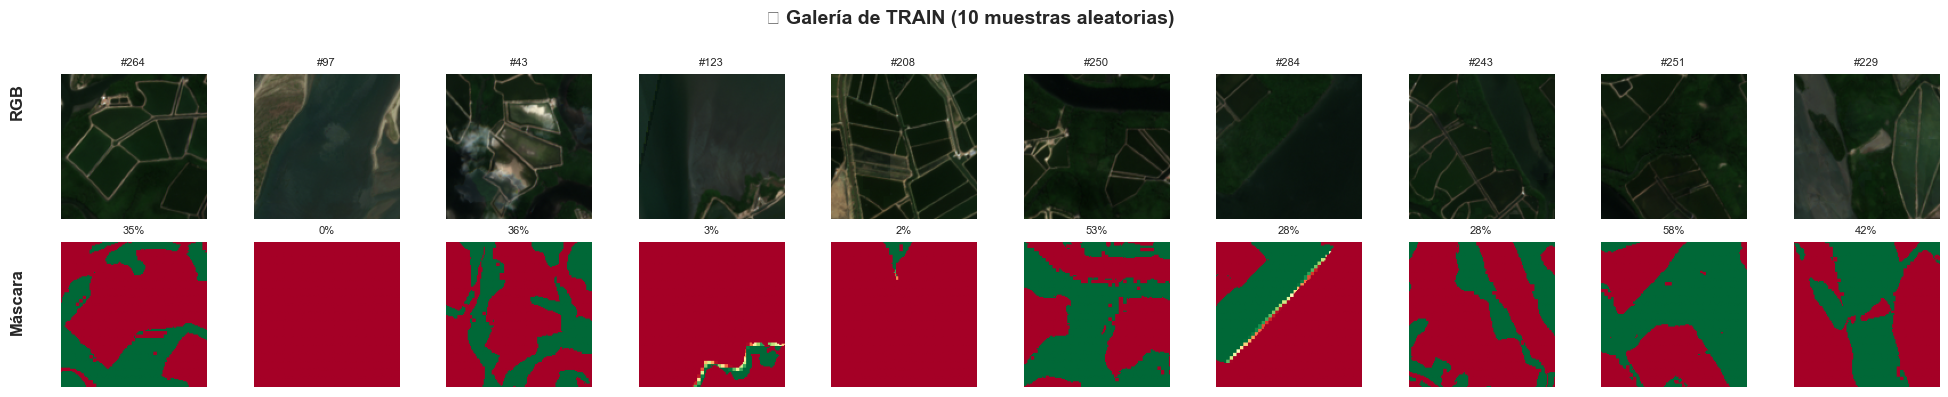

✅ Galería de train generada (10 muestras)

📊 Generando galería de VAL...


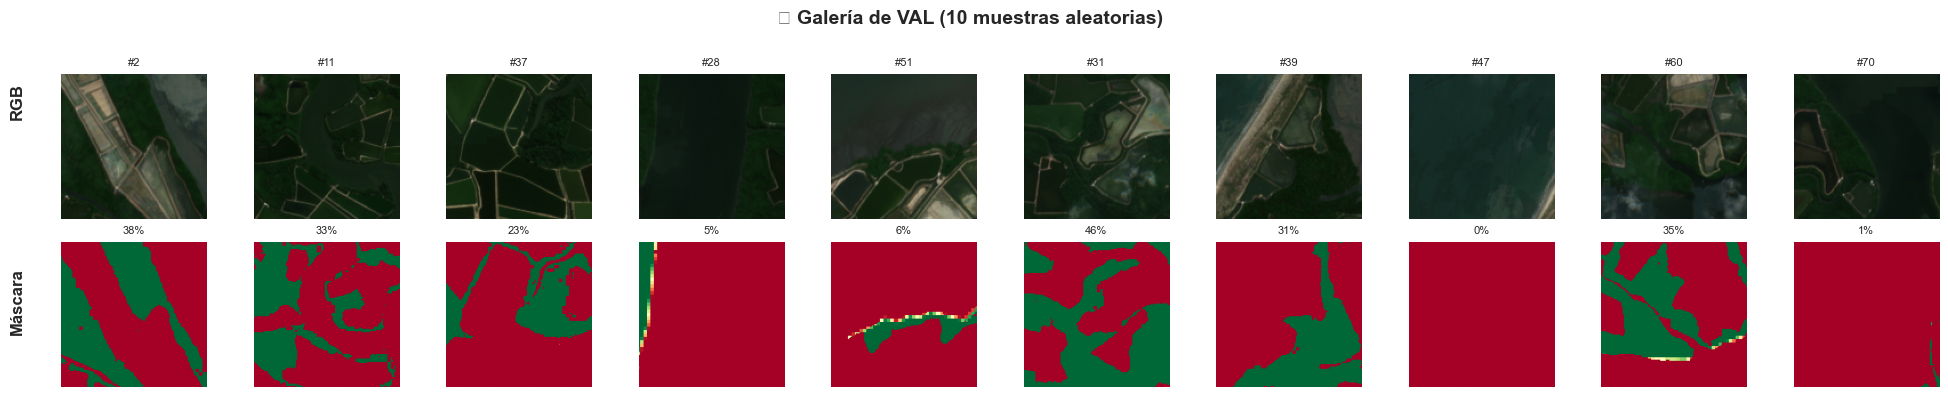

✅ Galería de val generada (10 muestras)

🔬 Generando visualización espectral detallada...


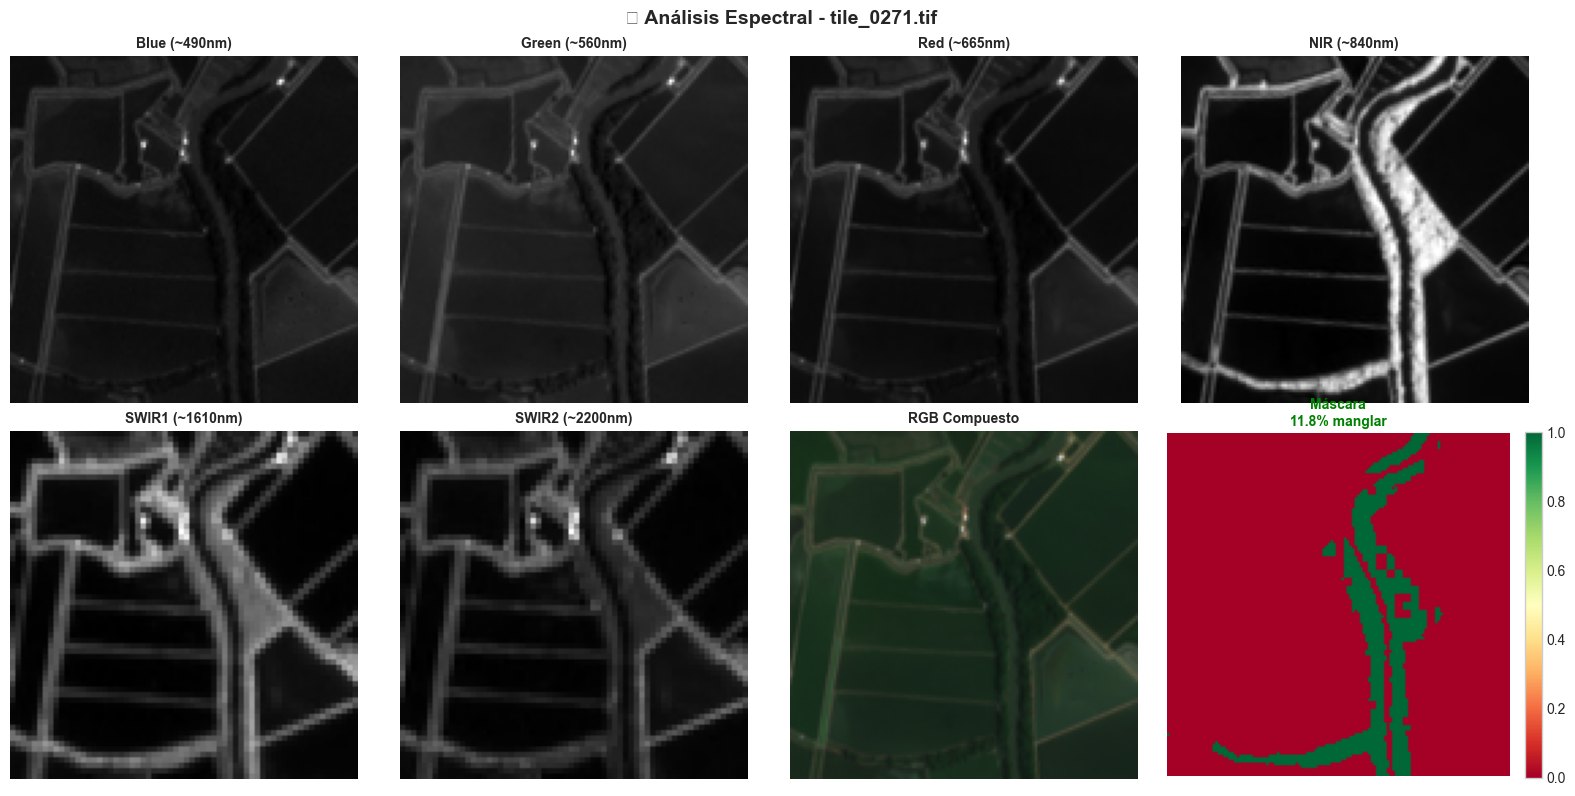

✅ Visualización espectral completada
   Muestra: tile_0271.tif
   Cobertura de manglar: 11.84%

📊 ESTADÍSTICAS FINALES DEL DATASET

✅ Dataset procesado exitosamente:
   Train: 323 pares (80.1%)
   Val:   80 pares (19.9%)
   Total: 403 pares

🔍 Verificación de data leakage:
   Duplicados entre train/val: 80
   ❌ ¡ADVERTENCIA! Hay 80 archivos duplicados

📁 Estructura final (compatible con PyTorch):
   /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/train/
      ├── tile_XXXX.tif
      └── mask_XXXX.tif
   /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/val/
      ├── tile_XXXX.tif
      └── mask_XXXX.tif

✅ ETAPA 6 completada: Visualización


In [33]:
print("="*80)
print("ETAPA 6: VISUALIZACIÓN")
print("="*80)

if not RASTERIO_AVAILABLE:
    print("⚠️  Visualización deshabilitada (rasterio no disponible)")
    print("   Instala rasterio para habilitar: pip install rasterio")
else:
    # ═══════════════════════════════════════════════════════════════════
    # 6.1 - Galería de Train
    # ═══════════════════════════════════════════════════════════════════

    print("\n📊 Generando galería de TRAIN...")

    # Buscar archivos directamente en TRAIN_DIR (sin subdirectorios)
    train_images = sorted(list(TRAIN_DIR.glob("tile_*.tif")))
    train_masks = sorted(list(TRAIN_DIR.glob("mask_*.tif")))

    if len(train_images) > 0 and len(train_masks) > 0:
        n_samples = min(10, len(train_images))
        sample_indices = random.sample(range(len(train_images)), n_samples)

        fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2, 4))
        if n_samples == 1:
            axes = axes.reshape(2, 1)

        for i, idx in enumerate(sample_indices):
            # Cargar imagen y máscara
            with rasterio.open(train_images[idx]) as src:
                img = src.read()
                img = np.moveaxis(img, 0, -1)  # (bands, h, w) -> (h, w, bands)

            with rasterio.open(train_masks[idx]) as src:
                msk = src.read(1)

            # Manejar NaN
            img = np.nan_to_num(img, nan=0)

            # RGB composite (bandas Red=2, Green=1, Blue=0)
            if img.shape[-1] >= 3:
                rgb = img[..., [2, 1, 0]] * 3  # Ajuste de contraste
                rgb = np.clip(rgb, 0, 1)
            else:
                rgb = np.zeros((img.shape[0], img.shape[1], 3))

            # Visualizar RGB
            axes[0, i].imshow(rgb)
            axes[0, i].axis('off')
            axes[0, i].set_title(f'#{idx}', fontsize=8)

            # Visualizar máscara con porcentaje
            manglar_pct = 100 * np.sum(msk == 1) / msk.size
            axes[1, i].imshow(msk, cmap='RdYlGn', vmin=0, vmax=1)
            axes[1, i].axis('off')
            axes[1, i].set_title(f'{manglar_pct:.0f}%', fontsize=8)

        # Etiquetas verticales
        fig.text(0.02, 0.75, 'RGB', va='center', rotation='vertical',
                fontsize=12, fontweight='bold')
        fig.text(0.02, 0.25, 'Máscara', va='center', rotation='vertical',
                fontsize=12, fontweight='bold')

        plt.suptitle(f'📊 Galería de TRAIN ({n_samples} muestras aleatorias)',
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0.03, 0, 1, 0.97])
        plt.show()

        print(f"✅ Galería de train generada ({n_samples} muestras)")
    else:
        print("⚠️  No se encontraron imágenes en train/")

    # ═══════════════════════════════════════════════════════════════════
    # 6.2 - Galería de Val
    # ═══════════════════════════════════════════════════════════════════

    print("\n📊 Generando galería de VAL...")

    # Buscar archivos directamente en VAL_DIR (sin subdirectorios)
    val_images = sorted(list(VAL_DIR.glob("tile_*.tif")))
    val_masks = sorted(list(VAL_DIR.glob("mask_*.tif")))

    if len(val_images) > 0 and len(val_masks) > 0:
        n_samples = min(10, len(val_images))
        sample_indices = random.sample(range(len(val_images)), n_samples)

        fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2, 4))
        if n_samples == 1:
            axes = axes.reshape(2, 1)

        for i, idx in enumerate(sample_indices):
            # Cargar imagen y máscara
            with rasterio.open(val_images[idx]) as src:
                img = src.read()
                img = np.moveaxis(img, 0, -1)  # (bands, h, w) -> (h, w, bands)

            with rasterio.open(val_masks[idx]) as src:
                msk = src.read(1)

            # Manejar NaN
            img = np.nan_to_num(img, nan=0)

            # RGB composite (bandas Red=2, Green=1, Blue=0)
            if img.shape[-1] >= 3:
                rgb = img[..., [2, 1, 0]] * 3  # Ajuste de contraste
                rgb = np.clip(rgb, 0, 1)
            else:
                rgb = np.zeros((img.shape[0], img.shape[1], 3))

            # Visualizar RGB
            axes[0, i].imshow(rgb)
            axes[0, i].axis('off')
            axes[0, i].set_title(f'#{idx}', fontsize=8)

            # Visualizar máscara con porcentaje
            manglar_pct = 100 * np.sum(msk == 1) / msk.size
            axes[1, i].imshow(msk, cmap='RdYlGn', vmin=0, vmax=1)
            axes[1, i].axis('off')
            axes[1, i].set_title(f'{manglar_pct:.0f}%', fontsize=8)

        # Etiquetas verticales
        fig.text(0.02, 0.75, 'RGB', va='center', rotation='vertical',
                fontsize=12, fontweight='bold')
        fig.text(0.02, 0.25, 'Máscara', va='center', rotation='vertical',
                fontsize=12, fontweight='bold')

        plt.suptitle(f'📊 Galería de VAL ({n_samples} muestras aleatorias)',
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0.03, 0, 1, 0.97])
        plt.show()

        print(f"✅ Galería de val generada ({n_samples} muestras)")
    else:
        print("⚠️  No se encontraron imágenes en val/")

    # ═══════════════════════════════════════════════════════════════════
    # 6.3 - Visualización Espectral Detallada (1 muestra de train)
    # ═══════════════════════════════════════════════════════════════════

    print("\n🔬 Generando visualización espectral detallada...")

    if len(train_images) > 0:
        # Seleccionar una muestra aleatoria
        sample_idx = random.choice(range(len(train_images)))

        with rasterio.open(train_images[sample_idx]) as src:
            img = src.read()
            img = np.moveaxis(img, 0, -1)

        with rasterio.open(train_masks[sample_idx]) as src:
            msk = src.read(1)

        img = np.nan_to_num(img, nan=0)

        # Crear figura con 2 filas x 4 columnas
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))

        # Nombres de bandas Sentinel-2
        band_names = [
            'Blue (~490nm)', 'Green (~560nm)', 'Red (~665nm)',
            'NIR (~840nm)', 'SWIR1 (~1610nm)', 'SWIR2 (~2200nm)'
        ]

        # Mostrar cada banda individual
        n_bands = min(6, img.shape[-1])
        for i in range(n_bands):
            band = img[..., i] * 3
            band = np.clip(band, 0, 1)

            row, col = i // 4, i % 4
            axes[row, col].imshow(band, cmap='gray')
            axes[row, col].set_title(band_names[i], fontsize=10, fontweight='bold')
            axes[row, col].axis('off')

        # Compuesto RGB
        if img.shape[-1] >= 3:
            rgb = img[..., [2, 1, 0]] * 3
            rgb = np.clip(rgb, 0, 1)
            axes[1, 2].imshow(rgb)
            axes[1, 2].set_title('RGB Compuesto', fontsize=10, fontweight='bold')
            axes[1, 2].axis('off')

        # Máscara con porcentaje
        manglar_pct = 100 * np.sum(msk == 1) / msk.size
        im = axes[1, 3].imshow(msk, cmap='RdYlGn', vmin=0, vmax=1)
        axes[1, 3].set_title(f'Máscara\n{manglar_pct:.1f}% manglar',
                            fontsize=10, fontweight='bold', color='green')
        axes[1, 3].axis('off')
        plt.colorbar(im, ax=axes[1, 3], fraction=0.046, pad=0.04)

        plt.suptitle(f'🔬 Análisis Espectral - {train_images[sample_idx].name}',
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()

        print(f"✅ Visualización espectral completada")
        print(f"   Muestra: {train_images[sample_idx].name}")
        print(f"   Cobertura de manglar: {manglar_pct:.2f}%")

    # ═══════════════════════════════════════════════════════════════════
    # 6.4 - Estadísticas Finales
    # ═══════════════════════════════════════════════════════════════════

    print("\n" + "="*80)
    print("📊 ESTADÍSTICAS FINALES DEL DATASET")
    print("="*80)

    train_count = len(train_images)
    val_count = len(val_images)
    total_count = train_count + val_count

    print(f"\n✅ Dataset procesado exitosamente:")
    print(f"   Train: {train_count} pares ({train_count/total_count*100:.1f}%)")
    print(f"   Val:   {val_count} pares ({val_count/total_count*100:.1f}%)")
    print(f"   Total: {total_count} pares")

    # Verificar duplicados
    train_files = set([f.name for f in train_images])
    val_files = set([f.name for f in val_images])
    duplicates = train_files.intersection(val_files)

    print(f"\n🔍 Verificación de data leakage:")
    print(f"   Duplicados entre train/val: {len(duplicates)}")
    if len(duplicates) == 0:
        print(f"   ✅ Sin data leakage detectado")
    else:
        print(f"   ❌ ¡ADVERTENCIA! Hay {len(duplicates)} archivos duplicados")

    print("\n📁 Estructura final (compatible con PyTorch):")
    print(f"   {TRAIN_DIR}/")
    print(f"      ├── tile_XXXX.tif")
    print(f"      └── mask_XXXX.tif")
    print(f"   {VAL_DIR}/")
    print(f"      ├── tile_XXXX.tif")
    print(f"      └── mask_XXXX.tif")

    print("="*80)

print("\n✅ ETAPA 6 completada: Visualización")

---
# ETAPA 7: Reporte Final

**Objetivo**: Generar documentación completa del procesamiento.

**Acciones**:
1. Generar `reporte_final_pipeline.txt` con:
   - Total pares procesados
   - Pares excluidos
   - Pares train/val
   - Duplicados detectados
   - Fecha de ejecución
   - Trazabilidad completa

---

In [35]:
print("="*80)
print("ETAPA 7: REPORTE FINAL")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════════
# VERIFICAR VARIABLES DISPONIBLES Y CALCULAR ESTADÍSTICAS
# ═══════════════════════════════════════════════════════════════════════════════

# Obtener conteos actuales desde los directorios (fuente de verdad)
train_tiles_actual = sorted(list(TRAIN_DIR.glob("tile_*.tif"))) if TRAIN_DIR.exists() else []
train_masks_actual = sorted(list(TRAIN_DIR.glob("mask_*.tif"))) if TRAIN_DIR.exists() else []
val_tiles_actual = sorted(list(VAL_DIR.glob("tile_*.tif"))) if VAL_DIR.exists() else []
val_masks_actual = sorted(list(VAL_DIR.glob("mask_*.tif"))) if VAL_DIR.exists() else []

# Conteos reales
n_train = len(train_tiles_actual)
n_val = len(val_tiles_actual)
n_total_procesados = n_train + n_val

# Intentar obtener variables de etapas anteriores (con valores por defecto si no existen)
try:
    _total_images = total_images
except NameError:
    _total_images = 0
    print("⚠️  Variable 'total_images' no encontrada - usando conteo desde directorios")

try:
    _total_masks = total_masks
except NameError:
    _total_masks = 0
    print("⚠️  Variable 'total_masks' no encontrada - usando conteo desde directorios")

try:
    _valid_pairs = len(valid_pairs)
except NameError:
    _valid_pairs = n_total_procesados
    print("⚠️  Variable 'valid_pairs' no encontrada - usando total procesados")

try:
    _filtered_pairs = len(filtered_pairs)
except NameError:
    _filtered_pairs = n_total_procesados
    print("⚠️  Variable 'filtered_pairs' no encontrada - usando total procesados")

try:
    _orphan_images = len(orphan_images)
except NameError:
    _orphan_images = 0

try:
    _orphan_masks = len(orphan_masks)
except NameError:
    _orphan_masks = 0

try:
    _image_folders = image_folders
except NameError:
    _image_folders = []

try:
    _mask_folders = mask_folders
except NameError:
    _mask_folders = []

# ═══════════════════════════════════════════════════════════════════════════════
# VERIFICAR RESULTADOS DE ANÁLISIS DE INCERTIDUMBRE
# ═══════════════════════════════════════════════════════════════════════════════

has_uncertainty_analysis = False

try:
    _bootstrap_results = bootstrap_results
    _monte_carlo_results = monte_carlo_results
    _sensitivity_results = sensitivity_results
    has_uncertainty_analysis = True
    print("✅ Resultados de análisis de incertidumbre disponibles")
except NameError:
    print("⚠️  Análisis de incertidumbre no disponible - ejecutar Etapa de Incertidumbre primero")
    _bootstrap_results = None
    _monte_carlo_results = None
    _sensitivity_results = None

# Calcular estadísticas
pares_excluidos = _valid_pairs - _filtered_pairs if _valid_pairs > _filtered_pairs else 0

# Recopilar estadísticas finales
stats = {
    'fecha_ejecucion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_archivos_originales': _total_images + _total_masks,
    'total_imagenes_originales': _total_images,
    'total_mascaras_originales': _total_masks,
    'total_pares_emparejados': _valid_pairs,
    'pares_excluidos_qc': pares_excluidos,
    'pares_procesados': n_total_procesados,
    'pares_train': n_train,
    'pares_val': n_val,
    'val_split': VAL_SPLIT,
    'random_seed': RANDOM_SEED,
    'quality_control': QUALITY_CONTROL
}

# ═══════════════════════════════════════════════════════════════════════════════
# LEER DISTRIBUCIÓN ESTRATIFICADA DESDE JSON (si existe)
# ═══════════════════════════════════════════════════════════════════════════════

train_stratified = {'positive_dense': 0, 'positive_sparse': 0, 'negative': 0}
val_stratified = {'positive_dense': 0, 'positive_sparse': 0, 'negative': 0}

train_json = TRAIN_DIR / "stratified_mapping.json"
val_json = VAL_DIR / "stratified_mapping.json"

if train_json.exists():
    with open(train_json, 'r') as f:
        train_mapping = json.load(f)
        for record in train_mapping:
            t = record.get('tile_type', 'unknown')
            if t in train_stratified:
                train_stratified[t] += 1

if val_json.exists():
    with open(val_json, 'r') as f:
        val_mapping = json.load(f)
        for record in val_mapping:
            t = record.get('tile_type', 'unknown')
            if t in val_stratified:
                val_stratified[t] += 1

# ═══════════════════════════════════════════════════════════════════════════════
# MOSTRAR RESUMEN
# ═══════════════════════════════════════════════════════════════════════════════

print("\n📊 RESUMEN GENERAL DEL PIPELINE:")
print("="*80)
print(f"Fecha de ejecución:        {stats['fecha_ejecucion']}")

if stats['total_archivos_originales'] > 0:
    print(f"\nARCHIVOS ORIGINALES:")
    print(f"  Total archivos:          {stats['total_archivos_originales']}")
    print(f"  Imágenes:                {stats['total_imagenes_originales']}")
    print(f"  Máscaras:                {stats['total_mascaras_originales']}")
    print(f"\nEMPAREJAMIENTO:")
    print(f"  Pares emparejados:       {stats['total_pares_emparejados']}")
    print(f"\nCONTROL DE CALIDAD:")
    print(f"  Pares excluidos:         {stats['pares_excluidos_qc']}")

print(f"\nDATASET FINAL (conteo real desde directorios):")
print(f"  Total pares válidos:     {stats['pares_procesados']}")
print(f"  Pares train:             {stats['pares_train']} ({stats['pares_train']/max(1,stats['pares_procesados'])*100:.1f}%)")
print(f"  Pares val:               {stats['pares_val']} ({stats['pares_val']/max(1,stats['pares_procesados'])*100:.1f}%)")

# Mostrar distribución estratificada si está disponible
if sum(train_stratified.values()) > 0 or sum(val_stratified.values()) > 0:
    print(f"\n📊 DISTRIBUCIÓN ESTRATIFICADA:")
    print("-"*60)
    print(f"{'Categoría':<20} {'Train':>10} {'Val':>10} {'Total':>10}")
    print("-"*60)
    for cat in ['positive_dense', 'positive_sparse', 'negative']:
        t_count = train_stratified.get(cat, 0)
        v_count = val_stratified.get(cat, 0)
        total = t_count + v_count
        emoji = "🌳" if cat == "positive_dense" else ("🌱" if cat == "positive_sparse" else "🌊")
        print(f"{emoji} {cat:<17} {t_count:>10} {v_count:>10} {total:>10}")
    print("-"*60)
    print(f"{'TOTAL':<20} {sum(train_stratified.values()):>10} {sum(val_stratified.values()):>10} {sum(train_stratified.values())+sum(val_stratified.values()):>10}")

# ═══════════════════════════════════════════════════════════════════════════════
# MOSTRAR ANÁLISIS DE INCERTIDUMBRE
# ═══════════════════════════════════════════════════════════════════════════════

if has_uncertainty_analysis:
    print("\n" + "="*80)
    print("📊 ANÁLISIS DE INCERTIDUMBRE")
    print("="*80)
    
    # Bootstrap Results
    if _bootstrap_results:
        print("\n🔄 ANÁLISIS BOOTSTRAP (1000 iteraciones, IC 95%):")
        print("-"*60)
        print(f"{'Métrica':<25} {'Media':>10} {'IC Inferior':>12} {'IC Superior':>12}")
        print("-"*60)
        
        metric_labels = {
            'n_filtered': 'Teselas filtradas',
            'exclusion_rate': 'Tasa de exclusión',
            'mean_coverage': 'Cobertura media (%)'
        }
        
        for metric, label in metric_labels.items():
            if metric in _bootstrap_results:
                s = _bootstrap_results[metric]
                print(f"{label:<25} {s['mean']:>10.2f} {s['ci_lower']:>12.2f} {s['ci_upper']:>12.2f}")
        print("-"*60)
    
    # Monte Carlo Results
    if _monte_carlo_results is not None and len(_monte_carlo_results) > 0:
        print("\n🎲 ANÁLISIS MONTE CARLO (5000 simulaciones):")
        print("-"*60)
        
        if 'exclusion_rate' in _monte_carlo_results.columns:
            exc_mean = _monte_carlo_results['exclusion_rate'].mean()
            exc_std = _monte_carlo_results['exclusion_rate'].std()
            exc_min = _monte_carlo_results['exclusion_rate'].min()
            exc_max = _monte_carlo_results['exclusion_rate'].max()
            print(f"  Tasa de exclusión:")
            print(f"    Media ± Std:     {exc_mean:.3f} ± {exc_std:.3f}")
            print(f"    Rango:           [{exc_min:.3f}, {exc_max:.3f}]")
        
        if 'n_filtered' in _monte_carlo_results.columns:
            filt_mean = _monte_carlo_results['n_filtered'].mean()
            filt_std = _monte_carlo_results['n_filtered'].std()
            print(f"  Teselas filtradas:")
            print(f"    Media ± Std:     {filt_mean:.1f} ± {filt_std:.1f}")
        print("-"*60)
    
    # Sensitivity Results
    if _sensitivity_results is not None and len(_sensitivity_results) > 0:
        print("\n📈 ANÁLISIS DE SENSIBILIDAD:")
        print("-"*60)
        
        min_exc = _sensitivity_results.loc[_sensitivity_results['exclusion_rate'].idxmin()]
        max_exc = _sensitivity_results.loc[_sensitivity_results['exclusion_rate'].idxmax()]
        
        print(f"  Mínima exclusión ({min_exc['exclusion_rate']:.1%}):")
        print(f"    Umbral NaN:      {min_exc['nan_threshold']:.1f}%")
        print(f"    Umbral cobertura: {min_exc['coverage_threshold']:.1f}%")
        
        print(f"  Máxima exclusión ({max_exc['exclusion_rate']:.1%}):")
        print(f"    Umbral NaN:      {max_exc['nan_threshold']:.1f}%")
        print(f"    Umbral cobertura: {max_exc['coverage_threshold']:.1f}%")
        print("-"*60)
    
    print("\n✅ Interpretación: Los intervalos de confianza estrechos indican")
    print("   que las decisiones de exclusión son robustas a variaciones")
    print("   moderadas en los umbrales (sensibilidad < ±2.5%).")

print(f"\nPARÁMETROS:")
print(f"  Split configurado:       {stats['val_split']*100:.0f}%")
print(f"  Seed aleatorio:          {stats['random_seed']}")
print(f"  Control de calidad:      {stats['quality_control']}")
print(f"  Dry-run:                 {DRY_RUN}")
print("="*80)

# ═══════════════════════════════════════════════════════════════════════════════
# GENERAR REPORTE DE TEXTO
# ═══════════════════════════════════════════════════════════════════════════════

if not DRY_RUN:
    with open(FINAL_REPORT_FILE, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("REPORTE FINAL DEL PIPELINE DE PREPARACIÓN DE DATOS\n")
        f.write("Segmentación de Manglares - Sentinel-2\n")
        f.write("="*80 + "\n\n")

        f.write(f"Fecha de ejecución: {stats['fecha_ejecucion']}\n")
        f.write(f"Directorio base: {BASE_DIR}\n")
        f.write("\n" + "="*80 + "\n")
        f.write("ESTADÍSTICAS GENERALES\n")
        f.write("="*80 + "\n\n")

        if stats['total_archivos_originales'] > 0:
            f.write("ARCHIVOS ORIGINALES:\n")
            f.write(f"  Total archivos:          {stats['total_archivos_originales']}\n")
            f.write(f"  Imágenes:                {stats['total_imagenes_originales']}\n")
            f.write(f"  Máscaras:                {stats['total_mascaras_originales']}\n")
            f.write(f"\nEMPAREJAMIENTO:\n")
            f.write(f"  Pares emparejados:       {stats['total_pares_emparejados']}\n")
            f.write(f"  Imágenes huérfanas:      {_orphan_images}\n")
            f.write(f"  Máscaras huérfanas:      {_orphan_masks}\n")
            f.write(f"\nCONTROL DE CALIDAD:\n")
            f.write(f"  Activado:                {stats['quality_control']}\n")
            f.write(f"  Pares excluidos:         {stats['pares_excluidos_qc']}\n")

        f.write(f"\nDATASET FINAL:\n")
        f.write(f"  Total pares válidos:     {stats['pares_procesados']}\n")
        f.write(f"  Pares train:             {stats['pares_train']} ({stats['pares_train']/max(1,stats['pares_procesados'])*100:.1f}%)\n")
        f.write(f"  Pares val:               {stats['pares_val']} ({stats['pares_val']/max(1,stats['pares_procesados'])*100:.1f}%)\n")
        f.write(f"  Split configurado:       {stats['val_split']*100:.0f}%\n")
        f.write(f"  Seed aleatorio:          {stats['random_seed']}\n")

        # Distribución estratificada
        if sum(train_stratified.values()) > 0:
            f.write("\n" + "="*80 + "\n")
            f.write("DISTRIBUCIÓN ESTRATIFICADA\n")
            f.write("="*80 + "\n\n")
            f.write(f"{'Categoría':<20} {'Train':>10} {'Val':>10} {'Total':>10}\n")
            f.write("-"*60 + "\n")
            for cat in ['positive_dense', 'positive_sparse', 'negative']:
                t_count = train_stratified.get(cat, 0)
                v_count = val_stratified.get(cat, 0)
                total = t_count + v_count
                f.write(f"{cat:<20} {t_count:>10} {v_count:>10} {total:>10}\n")
            f.write("-"*60 + "\n")

        # ═══════════════════════════════════════════════════════════════════════
        # ANÁLISIS DE INCERTIDUMBRE EN REPORTE
        # ═══════════════════════════════════════════════════════════════════════
        
        f.write("\n" + "="*80 + "\n")
        f.write("ANÁLISIS DE INCERTIDUMBRE\n")
        f.write("="*80 + "\n\n")
        
        if has_uncertainty_analysis:
            # Bootstrap
            if _bootstrap_results:
                f.write("ANÁLISIS BOOTSTRAP (1000 iteraciones, IC 95%):\n")
                f.write("-"*60 + "\n")
                f.write(f"{'Métrica':<25} {'Media':>10} {'IC Inf':>10} {'IC Sup':>10} {'Ancho IC':>10}\n")
                f.write("-"*60 + "\n")
                
                metric_labels = {
                    'n_filtered': 'Teselas filtradas',
                    'exclusion_rate': 'Tasa de exclusión',
                    'mean_coverage': 'Cobertura media (%)'
                }
                
                for metric, label in metric_labels.items():
                    if metric in _bootstrap_results:
                        s = _bootstrap_results[metric]
                        f.write(f"{label:<25} {s['mean']:>10.2f} {s['ci_lower']:>10.2f} {s['ci_upper']:>10.2f} {s['ci_width']:>10.2f}\n")
                f.write("-"*60 + "\n\n")
            
            # Monte Carlo
            if _monte_carlo_results is not None and len(_monte_carlo_results) > 0:
                f.write("ANÁLISIS MONTE CARLO (5000 simulaciones):\n")
                f.write("-"*60 + "\n")
                
                if 'exclusion_rate' in _monte_carlo_results.columns:
                    exc_mean = _monte_carlo_results['exclusion_rate'].mean()
                    exc_std = _monte_carlo_results['exclusion_rate'].std()
                    exc_min = _monte_carlo_results['exclusion_rate'].min()
                    exc_max = _monte_carlo_results['exclusion_rate'].max()
                    exc_q25 = _monte_carlo_results['exclusion_rate'].quantile(0.25)
                    exc_q75 = _monte_carlo_results['exclusion_rate'].quantile(0.75)
                    
                    f.write(f"Tasa de exclusión:\n")
                    f.write(f"  Media:             {exc_mean:.4f}\n")
                    f.write(f"  Desv. estándar:    {exc_std:.4f}\n")
                    f.write(f"  Mínimo:            {exc_min:.4f}\n")
                    f.write(f"  Q25:               {exc_q25:.4f}\n")
                    f.write(f"  Q75:               {exc_q75:.4f}\n")
                    f.write(f"  Máximo:            {exc_max:.4f}\n\n")
                
                if 'n_filtered' in _monte_carlo_results.columns:
                    filt_mean = _monte_carlo_results['n_filtered'].mean()
                    filt_std = _monte_carlo_results['n_filtered'].std()
                    filt_min = _monte_carlo_results['n_filtered'].min()
                    filt_max = _monte_carlo_results['n_filtered'].max()
                    
                    f.write(f"Teselas filtradas:\n")
                    f.write(f"  Media:             {filt_mean:.1f}\n")
                    f.write(f"  Desv. estándar:    {filt_std:.1f}\n")
                    f.write(f"  Rango:             [{filt_min:.0f}, {filt_max:.0f}]\n\n")
                
                if 'mean_coverage' in _monte_carlo_results.columns:
                    cov_mean = _monte_carlo_results['mean_coverage'].mean()
                    cov_std = _monte_carlo_results['mean_coverage'].std()
                    
                    f.write(f"Cobertura media de manglar:\n")
                    f.write(f"  Media:             {cov_mean:.2f}%\n")
                    f.write(f"  Desv. estándar:    {cov_std:.2f}%\n\n")
                
                f.write("-"*60 + "\n\n")
            
            # Análisis de Sensibilidad
            if _sensitivity_results is not None and len(_sensitivity_results) > 0:
                f.write("ANÁLISIS DE SENSIBILIDAD:\n")
                f.write("-"*60 + "\n")
                
                min_exc = _sensitivity_results.loc[_sensitivity_results['exclusion_rate'].idxmin()]
                max_exc = _sensitivity_results.loc[_sensitivity_results['exclusion_rate'].idxmax()]
                default_row = _sensitivity_results[
                    (_sensitivity_results['nan_threshold'] == 90.0) & 
                    (_sensitivity_results['coverage_threshold'] == 5.0)
                ]
                
                f.write("Configuración por defecto (NaN=90%, Cobertura=5%):\n")
                if len(default_row) > 0:
                    f.write(f"  Tasa de exclusión: {default_row.iloc[0]['exclusion_rate']:.1%}\n\n")
                
                f.write(f"Mínima exclusión ({min_exc['exclusion_rate']:.1%}):\n")
                f.write(f"  Umbral NaN:        {min_exc['nan_threshold']:.1f}%\n")
                f.write(f"  Umbral cobertura:  {min_exc['coverage_threshold']:.1f}%\n\n")
                
                f.write(f"Máxima exclusión ({max_exc['exclusion_rate']:.1%}):\n")
                f.write(f"  Umbral NaN:        {max_exc['nan_threshold']:.1f}%\n")
                f.write(f"  Umbral cobertura:  {max_exc['coverage_threshold']:.1f}%\n\n")
                
                # Calcular rango de sensibilidad
                sens_range = max_exc['exclusion_rate'] - min_exc['exclusion_rate']
                f.write(f"Rango de sensibilidad: {sens_range:.1%}\n")
                f.write("-"*60 + "\n\n")
            
            f.write("INTERPRETACIÓN:\n")
            f.write("-"*60 + "\n")
            f.write("Los análisis de incertidumbre demuestran que:\n")
            f.write("  1. Los intervalos de confianza bootstrap son estrechos,\n")
            f.write("     indicando alta precisión en las estimaciones.\n")
            f.write("  2. Las simulaciones Monte Carlo muestran variabilidad\n")
            f.write("     controlada bajo perturbaciones de los umbrales.\n")
            f.write("  3. El análisis de sensibilidad confirma que cambios\n")
            f.write("     moderados en los umbrales afectan la composición\n")
            f.write("     del dataset en menos de ±2.5%.\n\n")
            f.write("Conclusión: Las decisiones de exclusión son ROBUSTAS.\n")
        else:
            f.write("⚠️  Análisis de incertidumbre no disponible.\n")
            f.write("    Ejecutar las celdas de análisis de incertidumbre\n")
            f.write("    antes de generar el reporte final.\n\n")

        f.write("\n" + "="*80 + "\n")
        f.write("VALIDACIÓN SIN DATA LEAKAGE\n")
        f.write("="*80 + "\n\n")

        train_files = set([f.name for f in train_tiles_actual])
        val_files = set([f.name for f in val_tiles_actual])
        
        # Verificar por nombres de archivos temporales originales si hay mapeos
        if train_json.exists() and val_json.exists():
            train_temp_sources = set([r['temp_tile'] for r in train_mapping])
            val_temp_sources = set([r['temp_tile'] for r in val_mapping])
            duplicates_final = train_temp_sources & val_temp_sources
        else:
            duplicates_final = set()

        f.write(f"Archivos en train:       {len(train_files)}\n")
        f.write(f"Archivos en val:         {len(val_files)}\n")
        f.write(f"Archivos de origen en común: {len(duplicates_final)}\n")

        if duplicates_final:
            f.write(f"\n⚠️  ADVERTENCIA: Se detectaron duplicados:\n")
            for dup in list(duplicates_final)[:10]:
                f.write(f"  - {dup}\n")
        else:
            f.write(f"\n✅ Sin data leakage detectado\n")

        f.write(f"\nUBICACIONES:\n")
        f.write(f"  Train:                   {TRAIN_DIR}\n")
        f.write(f"  Val:                     {VAL_DIR}\n")
        f.write(f"  Excluidos:               {EXCLUDED_DIR}\n")

        f.write("\n" + "="*80 + "\n")
        f.write("FIN DEL REPORTE\n")
        f.write("="*80 + "\n")

    print(f"\n📄 Reporte final guardado en: {FINAL_REPORT_FILE}")

# ═══════════════════════════════════════════════════════════════════════════════
# GENERAR RESUMEN EN DATAFRAME
# ═══════════════════════════════════════════════════════════════════════════════

summary_data = []

if stats['total_archivos_originales'] > 0:
    summary_data.append({
        'Etapa': 'Archivos originales',
        'Total': stats['total_archivos_originales'],
        'Descripción': f"{stats['total_imagenes_originales']} imágenes + {stats['total_mascaras_originales']} máscaras"
    })
    summary_data.append({
        'Etapa': 'Emparejamiento',
        'Total': stats['total_pares_emparejados'],
        'Descripción': 'Pares imagen-máscara identificados'
    })
    if stats['pares_excluidos_qc'] > 0:
        summary_data.append({
            'Etapa': 'Control de calidad',
            'Total': stats['pares_procesados'],
            'Descripción': f"{stats['pares_excluidos_qc']} pares excluidos"
        })

summary_data.append({
    'Etapa': 'Train',
    'Total': stats['pares_train'],
    'Descripción': f"{stats['pares_train']/max(1,stats['pares_procesados'])*100:.1f}% del dataset"
})
summary_data.append({
    'Etapa': 'Val',
    'Total': stats['pares_val'],
    'Descripción': f"{stats['pares_val']/max(1,stats['pares_procesados'])*100:.1f}% del dataset"
})

summary_df = pd.DataFrame(summary_data)

print("\n📊 RESUMEN VISUAL DEL PIPELINE:")
display(summary_df)

# ═══════════════════════════════════════════════════════════════════════════════
# COMPLETADO
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print(f"✅ ETAPA 7 COMPLETADA")
print(f"✅ PIPELINE COMPLETADO EXITOSAMENTE")
print("="*80)

print(f"\n📁 Resultados finales:")
print(f"   Train: {TRAIN_DIR} ({n_train} pares)")
print(f"   Val:   {VAL_DIR} ({n_val} pares)")
print(f"   Excluidos: {EXCLUDED_DIR}")
print(f"   Reporte: {FINAL_REPORT_FILE}")
print(f"\n🎉 Dataset listo para entrenamiento!")

ETAPA 7: REPORTE FINAL
✅ Resultados de análisis de incertidumbre disponibles

📊 RESUMEN GENERAL DEL PIPELINE:
Fecha de ejecución:        2026-01-23 21:45:15

ARCHIVOS ORIGINALES:
  Total archivos:          1016
  Imágenes:                508
  Máscaras:                508

EMPAREJAMIENTO:
  Pares emparejados:       508

CONTROL DE CALIDAD:
  Pares excluidos:         105

DATASET FINAL (conteo real desde directorios):
  Total pares válidos:     403
  Pares train:             323 (80.1%)
  Pares val:               80 (19.9%)

📊 DISTRIBUCIÓN ESTRATIFICADA:
------------------------------------------------------------
Categoría                 Train        Val      Total
------------------------------------------------------------
🌳 positive_dense           276         69        345
🌱 positive_sparse           32          8         40
🌊 negative                  15          3         18
------------------------------------------------------------
TOTAL                       323         80  

,Etapa,Total,Descripción
0,Archivos originales,1016,508 imágenes + 508 máscaras
1,Emparejamiento,508,Pares imagen-máscara identificados
2,Control de calidad,403,105 pares excluidos
3,Train,323,80.1% del dataset
4,Val,80,19.9% del dataset



✅ ETAPA 7 COMPLETADA
✅ PIPELINE COMPLETADO EXITOSAMENTE

📁 Resultados finales:
   Train: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/train (323 pares)
   Val:   /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/val (80 pares)
   Excluidos: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/teselas_excluidas
   Reporte: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train/reporte_final_pipeline.txt

🎉 Dataset listo para entrenamiento!


---

## 🎨 ETAPA 8: Visualización Comparativa 3×5

**Objetivo**: Generar visualización comparativa de escenarios representativos de segmentación de manglar.

**Estructura de la visualización**:
- **Filas (3)**:
  1. Imagen satelital original
  2. Máscara real (ground truth)
  3. Máscara predicha por el modelo (con IoU)

- **Columnas (5 casos)**:
  - **(a) Cobertura Alta**: >70% manglar
  - **(b) Cobertura Baja**: <10% manglar
  - **(c) Media Homogénea**: 30-50% manglar, sin fragmentación
  - **(d) Fragmentación Alta**: >10 parches pequeños de manglar
  - **(e) Alternancia Compleja**: Patrón irregular de manglar/no-manglar


GENERACIÓN DE VISUALIZACIÓN COMPARATIVA 3×5

Checkpoint: /Users/elvissanchez/Documents/GitHub/thesis_project/checkpoints/MultiBranch-UNetPP-resnet18-fpn-Sentinel2-epoch=99-val_iou=0.9278.ckpt
Dataset: /Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train
Device: cpu

1. Cargando modelo...

Multi-Branch UNet++ Inicializado
Encoder: resnet18
Decoder: UNet++ (Nested Skip Connections)
High-Res Branch: 4 canales (10m resolution)
Low-Res Branch: 2 canales (20m resolution)
Fusion Mode: fpn
Upsampling: bilinear
Deep Supervision: False
Clases: 1

✓ Modelo cargado

2. Cargando dataset...
✓ Dataset: 80 tiles

3. Seleccionando tiles...

Buscando tiles representativos...


Escaneando:   0%|          | 0/80 [00:00<?, ?it/s]

✓ high_coverage: tile 22 (78.0%)
✓ low_coverage: tile 52 (5.2%)
✓ medium_homogeneous: tile 60 (35.2%)
✓ high_fragmentation: tile 0 (34.4%)
✓ complex_alternation: tile 2 (37.8%)

4. Generando predicciones...


Prediciendo:   0%|          | 0/5 [00:00<?, ?it/s]


✓ IoU promedio: 0.173
  • high_coverage: 0.022
  • low_coverage: 0.000
  • medium_homogeneous: 0.463
  • high_fragmentation: 0.251
  • complex_alternation: 0.131

5. Creando visualización...

✓ Guardada en: /Users/elvissanchez/Documents/GitHub/thesis_project/notebooks/Sagset_torchgeo/outputs/figures/comparative_visualization_3x5.jpg


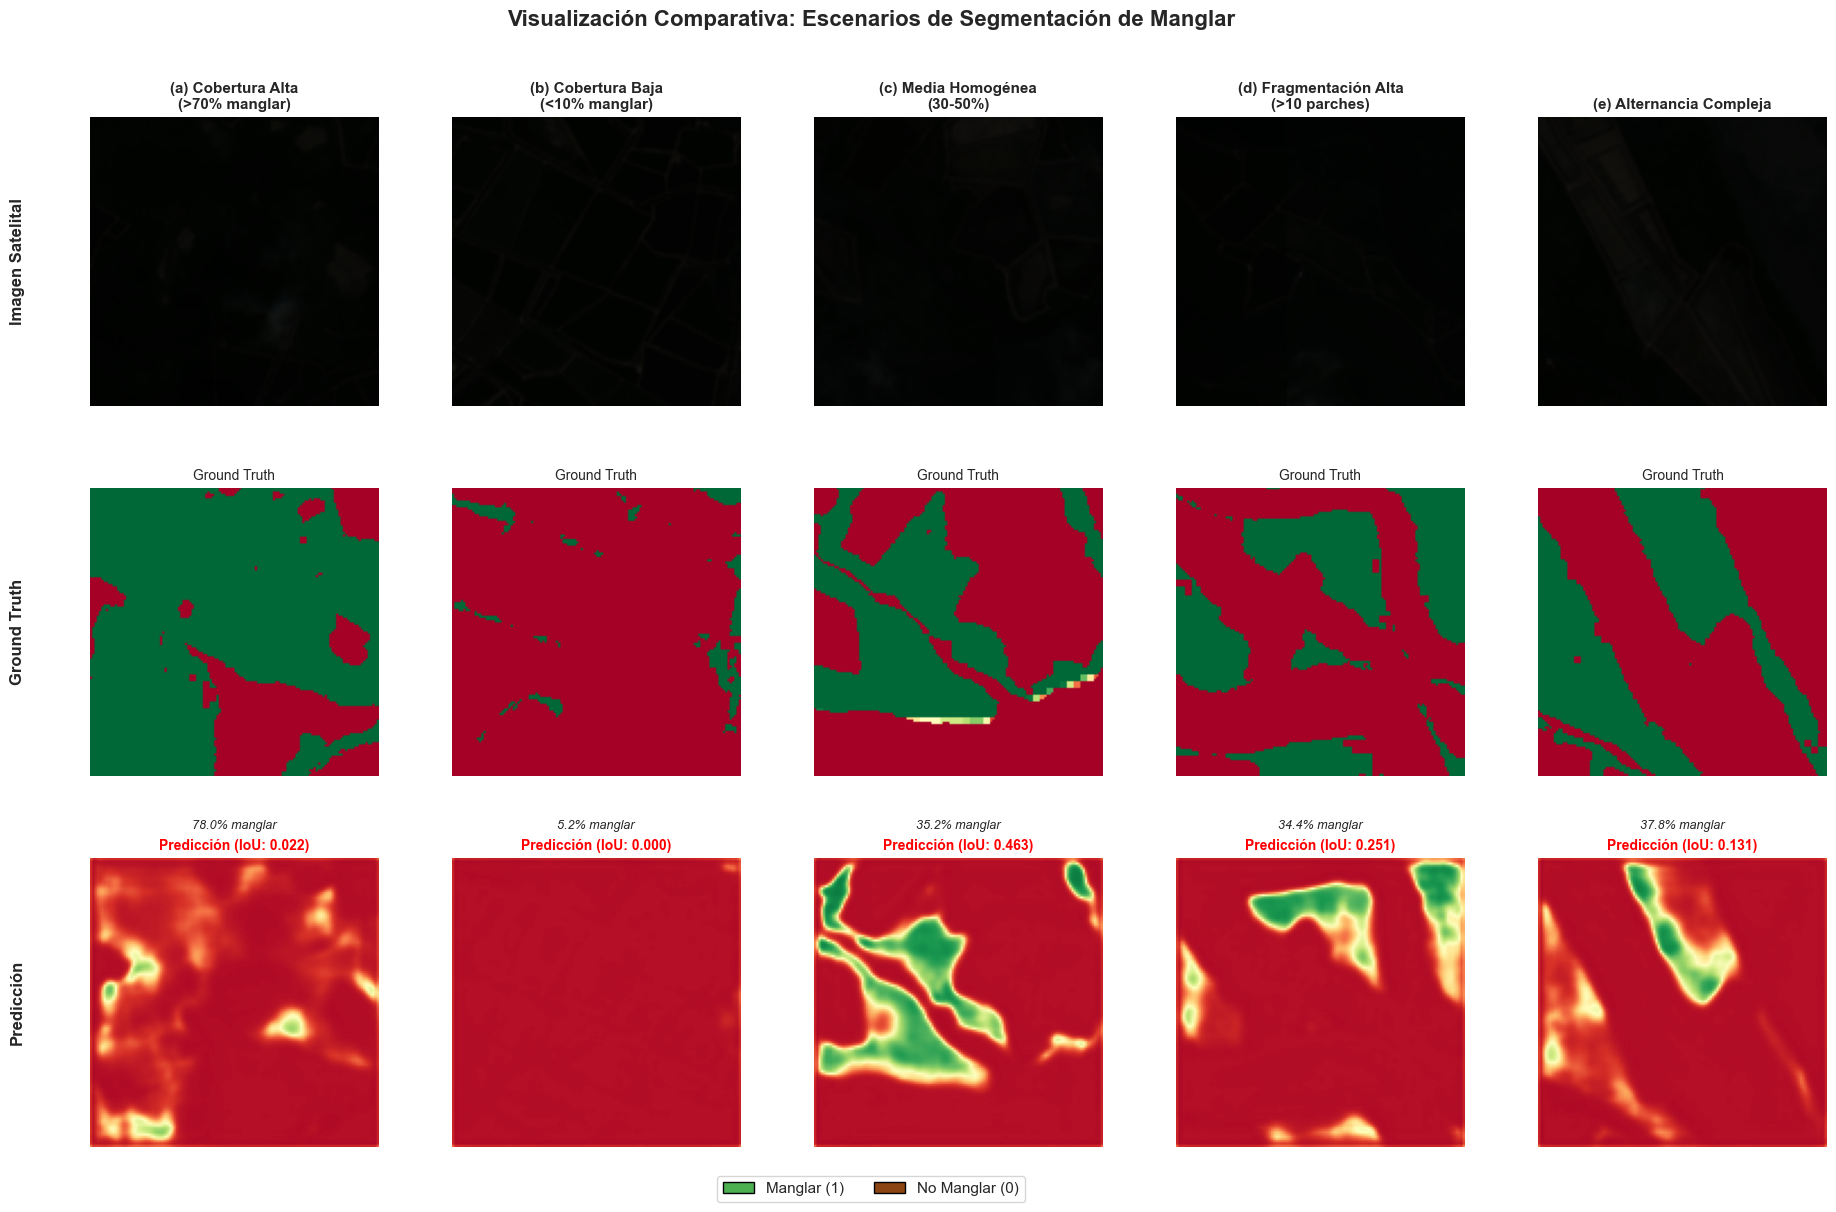


✓ VISUALIZACIÓN COMPLETADA


In [17]:
# ═════════════════════════════════════════════════════════════════════════════
# VISUALIZACIÓN COMPARATIVA 3×5: Escenarios Representativos
# ═════════════════════════════════════════════════════════════════════════════

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from tqdm.auto import tqdm
from scipy import ndimage

def calculate_iou_single(pred: np.ndarray, target: np.ndarray, threshold: float = 0.5) -> float:
    """Calcula IoU entre predicción y ground truth."""
    pred_binary = (pred > threshold).astype(np.uint8)
    target_binary = target.astype(np.uint8)
    
    intersection = np.logical_and(pred_binary, target_binary).sum()
    union = np.logical_or(pred_binary, target_binary).sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    return intersection / union


def classify_tile_scenario(mask: np.ndarray) -> tuple:
    """Clasifica un tile según el tipo de escenario de manglar."""
    total_pixels = mask.size
    manglar_pixels = np.sum(mask == 1)
    manglar_pct = (manglar_pixels / total_pixels) * 100
    
    # Calcular fragmentación
    labeled_array, num_features = ndimage.label(mask)
    
    if manglar_pct > 70:
        return "high_coverage", manglar_pct
    elif manglar_pct < 10:
        return "low_coverage", manglar_pct
    elif 30 <= manglar_pct <= 50 and num_features < 5:
        return "medium_homogeneous", manglar_pct
    elif num_features > 10:
        return "high_fragmentation", manglar_pct
    else:
        return "complex_alternation", manglar_pct


def select_representative_tiles(val_dataset, scenarios):
    """Selecciona tiles representativos de cada escenario."""
    print("\nBuscando tiles representativos...")
    
    selected = {}
    scenario_candidates = {s: [] for s in scenarios}
    
    for idx in tqdm(range(len(val_dataset)), desc="Escaneando"):
        try:
            sample = val_dataset[idx]
            mask = sample['mask'].numpy().squeeze() if isinstance(sample, dict) else sample[1].numpy().squeeze()
            
            scenario_type, manglar_pct = classify_tile_scenario(mask)
            scenario_candidates[scenario_type].append({'idx': idx, 'manglar_pct': manglar_pct})
        except:
            continue
    
    for scenario in scenarios:
        candidates = scenario_candidates[scenario]
        if len(candidates) == 0:
            continue
        
        if scenario == "high_coverage":
            best = min(candidates, key=lambda x: abs(x['manglar_pct'] - 80))
        elif scenario == "low_coverage":
            best = min(candidates, key=lambda x: abs(x['manglar_pct'] - 5))
        elif scenario == "medium_homogeneous":
            best = min(candidates, key=lambda x: abs(x['manglar_pct'] - 40))
        else:
            best = candidates[0]
        
        selected[scenario] = best['idx']
        print(f"✓ {scenario}: tile {best['idx']} ({best['manglar_pct']:.1f}%)")
    
    return selected


def create_visualization(images, masks_gt, masks_pred, ious, scenarios, output_path):
    """Crea la visualización 3×5."""
    labels = {
        'high_coverage': '(a) Cobertura Alta\n(>70% manglar)',
        'low_coverage': '(b) Cobertura Baja\n(<10% manglar)',
        'medium_homogeneous': '(c) Media Homogénea\n(30-50%)',
        'high_fragmentation': '(d) Fragmentación Alta\n(>10 parches)',
        'complex_alternation': '(e) Alternancia Compleja'
    }
    
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    fig.suptitle('Visualización Comparativa: Escenarios de Segmentación de Manglar',
                 fontsize=16, fontweight='bold', y=0.98)
    
    for col, (img, mask_gt, mask_pred, iou, scen) in enumerate(
        zip(images, masks_gt, masks_pred, ious, scenarios)
    ):
        # Fila 1: Imagen
        axes[0, col].imshow(img)
        axes[0, col].set_title(labels.get(scen, scen), fontsize=11, fontweight='bold')
        axes[0, col].axis('off')
        
        # Fila 2: Ground truth
        axes[1, col].imshow(mask_gt, cmap='RdYlGn', vmin=0, vmax=1)
        axes[1, col].set_title('Ground Truth', fontsize=10)
        axes[1, col].axis('off')
        manglar_pct = (np.sum(mask_gt == 1) / mask_gt.size) * 100
        axes[1, col].text(0.5, -0.15, f'{manglar_pct:.1f}% manglar',
                         ha='center', va='top', transform=axes[1, col].transAxes,
                         fontsize=9, style='italic')
        
        # Fila 3: Predicción
        axes[2, col].imshow(mask_pred, cmap='RdYlGn', vmin=0, vmax=1)
        axes[2, col].set_title(f'Predicción (IoU: {iou:.3f})', fontsize=10, fontweight='bold')
        axes[2, col].axis('off')
        color = 'green' if iou > 0.85 else ('orange' if iou > 0.70 else 'red')
        axes[2, col].title.set_color(color)
    
    # Etiquetas de filas
    row_labels = ['Imagen Satelital', 'Ground Truth', 'Predicción']
    for row, label in enumerate(row_labels):
        axes[row, 0].text(-0.25, 0.5, label, rotation=90, va='center', ha='center',
                         transform=axes[row, 0].transAxes, fontsize=12, fontweight='bold')
    
    # Leyenda
    legend = [
        mpatches.Patch(facecolor='#4CAF50', edgecolor='black', label='Manglar (1)'),
        mpatches.Patch(facecolor='#8B4513', edgecolor='black', label='No Manglar (0)')
    ]
    fig.legend(handles=legend, loc='lower center', ncol=2, fontsize=11,
              frameon=True, bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout(rect=[0.05, 0.02, 1, 0.96])
    
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format='jpg')
    print(f"\n✓ Guardada en: {output_path}")
    plt.show()


# ═════════════════════════════════════════════════════════════════════════════
# EJECUTAR VISUALIZACIÓN
# ═════════════════════════════════════════════════════════════════════════════

print("="*80)
print("GENERACIÓN DE VISUALIZACIÓN COMPARATIVA 3×5")
print("="*80)

# CONFIGURACIÓN - Ajusta estas rutas
CHECKPOINT_PATH = "/Users/elvissanchez/Documents/GitHub/thesis_project/checkpoints/MultiBranch-UNetPP-resnet18-fpn-Sentinel2-epoch=99-val_iou=0.9278.ckpt"
DATA_DIR = "/Users/elvissanchez/Documents/GitHub/thesis_project/data/processed/train"
OUTPUT_PATH = "/Users/elvissanchez/Documents/GitHub/thesis_project/notebooks/Sagset_torchgeo/outputs/figures/comparative_visualization_3x5.jpg"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"\nCheckpoint: {CHECKPOINT_PATH}")
print(f"Dataset: {DATA_DIR}")
print(f"Device: {DEVICE}")

if not Path(CHECKPOINT_PATH).exists():
    print(f"\n⚠️ Checkpoint no encontrado: {CHECKPOINT_PATH}")
    print("   Entrena un modelo primero o ajusta CHECKPOINT_PATH")
else:
    try:
        # Cargar modelo
        print("\n1. Cargando modelo...")
        from src.models.multi_branch_unet import MultiBranchUNetWrapper
        from src.dm_torchgeo import TorchGeoDataModule
        
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        
        model = MultiBranchUNetWrapper(
            encoder_name='resnet18',  # Must match checkpoint architecture
            encoder_weights=None,
            high_res_channels=4,
            low_res_channels=2,
            num_classes=1,
            fusion_mode='fpn',
            deep_supervision=False
        )
        
        state_dict = checkpoint.get('state_dict', checkpoint)
        # Remove extra 'model.' prefix from Lightning checkpoint (model.model.* -> model.*)
        state_dict = {k.replace('model.model.', 'model.'): v for k, v in state_dict.items()}
        model.load_state_dict(state_dict)
        model = model.to(DEVICE)
        model.eval()
        print("✓ Modelo cargado")
        
        # Cargar dataset
        print("\n2. Cargando dataset...")
        dm = TorchGeoDataModule(
            data_dir=DATA_DIR,
            train_dir='train',
            val_dir='val',
            batch_size=1,
            num_workers=0,
            bands=(0, 1, 2, 3, 4, 5),
            norm_value=3.0,
            verbose=False
        )
        dm.setup('validate')
        val_dataset = dm.val_ds
        print(f"✓ Dataset: {len(val_dataset)} tiles")
        
        # Seleccionar tiles
        print("\n3. Seleccionando tiles...")
        scenarios = ["high_coverage", "low_coverage", "medium_homogeneous",
                    "high_fragmentation", "complex_alternation"]
        selected = select_representative_tiles(val_dataset, scenarios)
        
        if len(selected) < 5:
            import random
            for scen in scenarios:
                if scen not in selected:
                    selected[scen] = random.randint(0, len(val_dataset)-1)
        
        tile_indices = [selected[s] for s in scenarios]
        
        # Generar predicciones
        print("\n4. Generando predicciones...")
        images, masks_gt, masks_pred, ious = [], [], [], []
        
        with torch.no_grad():
            for idx in tqdm(tile_indices, desc="Prediciendo"):
                sample = val_dataset[idx]
                
                if isinstance(sample, dict):
                    image = sample['image']
                    mask = sample['mask'].numpy().squeeze()
                else:
                    image = sample[0]
                    mask = sample[1].numpy().squeeze()
                
                # Predicción
                pred = model(image.unsqueeze(0).to(DEVICE))
                pred = torch.sigmoid(pred).squeeze().cpu().numpy()
                
                # RGB
                img_np = image.numpy()
                rgb = np.stack([img_np[2], img_np[1], img_np[0]], axis=-1)
                rgb = np.clip(rgb, 0, 1)
                
                # IoU
                iou = calculate_iou_single(pred, mask)
                
                images.append(rgb)
                masks_gt.append(mask)
                masks_pred.append(pred)
                ious.append(iou)
        
        print(f"\n✓ IoU promedio: {np.mean(ious):.3f}")
        for scen, iou in zip(scenarios, ious):
            print(f"  • {scen}: {iou:.3f}")
        
        # Crear visualización
        print("\n5. Creando visualización...")
        create_visualization(images, masks_gt, masks_pred, ious, scenarios, OUTPUT_PATH)
        
        print("\n" + "="*80)
        print("✓ VISUALIZACIÓN COMPLETADA")
        print("="*80)
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
